# Optimization of E. coli growth parameters for NUFEB
This notebook utilizes hyperparameter optimization to fit simulated E. coli growth curves to experimental data. Under the hood, we use scikit-optimize to perform a Bayesian optimization.

In [5]:
#Imports
import os
from random import uniform
from pathlib import Path
from nufeb_tools import utils,plot
import pandas as pd
from string import Template
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
import subprocess
from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize,load
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence, plot_objective,plot_gaussian_process
from scipy.optimize import curve_fit
from scipy import interpolate

In [6]:
from tqdm.notebook import tqdm
class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        self._bar.update()

    def __getstate__(self):
        state = self.__dict__.copy()
        del state['_bar']
        return state

In [18]:
expPath = r'../experimental-data/ecw-growth-R2.xlsx'
growthData = pd.read_excel(expPath,sheet_name='Growth')
expSucrose =pd.read_excel(expPath,sheet_name='Sucrose')

In [19]:
growthData = growthData.loc[growthData['Initial Sucrose'] !=20]
growthData=growthData.groupby(['Time','Initial Sucrose']).mean().reset_index()[['Time','Initial Sucrose','OD600']]
growthData.head()

Time  Initial Sucrose     OD600
0     0                2  0.010000
1     0                5  0.010000
2     0               10  0.010000
3     1                2  0.010000
4     1                5  0.016333

In [68]:
expSucrose = expSucrose.loc[expSucrose['Initial Sucrose'] !=20]
expSucrose = expSucrose.groupby(['Time','Initial Sucrose']).mean().reset_index()[['Time','Initial Sucrose','Sucrose']]
expSucrose.head()

Time  Initial Sucrose   Sucrose
0     0                2  1.855295
1     0                5  4.685920
2     0               10  9.489184
3     4                2  1.808598
4     4                5  4.631757

# Optimization function
## Parameters to optimize:
### $\mu_{max}$ (Monod-based growth rate, $s^{-1}$)
### $\rho$ (Cell density, $\frac{kg}{m^3}$)
### $k_{sucrose}$ (Sucrose uptake half-maximum, $\frac{kg}{m^3}$)
### m (Cellular maintenance cost, $s^{-1}$)

In [13]:
Volume = 1e-4*1e-4*1e-4 #m^3
mlm3 = 1e6 #mL/m^3
Biomass2OD = Volume*.44


In [12]:
def mu_func(x,K,r,N0):
    return K/(1  + ((K-N0)/N0)*np.exp(-r*x))

In [46]:
def collect_data(folder):
    SucroseMW = 342.3
    x = utils.get_data(directory=str(folder))
    Volume = np.prod(x.metadata['Dimensions'])
    Biomass2OD = .44*Volume*1e18
    temp = pd.concat([x.biomass.ecw.reset_index(drop=True)/Biomass2OD,x.biomass.step.reset_index(drop=True)/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
    temp.columns=['OD600','Hours','Sucrose']
    temp['Sucrose']=temp['Sucrose']*SucroseMW*1e-3
    temp['S0'] = temp.Sucrose.iloc[0]
    return temp

In [47]:
os.chdir('/home/jsakkos/NUFEB')
os.system('nufeb-clean')
SucroseMW = 342.3
for s in growthData['Initial Sucrose'].unique():
    suc = s*1e3/SucroseMW
    text = f'nufeb-seed --n 3 --od 0,0.01 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --suc {suc} --niter 10'
    os.system(text)
#Run new simulations
os.system('/home/jsakkos/par.sh')
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

tmp=Parallel(n_jobs=-1)(delayed(collect_data)(folder) for folder in folders)
data = pd.concat(tmp,ignore_index=True)
df = data.groupby(['Hours','S0']).mean().reset_index()

In [48]:
df

Hours    S0     OD600    Sucrose
0     0.000000   2.0  0.006233   2.000000
1     0.000000   5.0  0.006218   5.000000
2     0.000000  10.0  0.006215  10.000000
3     0.277778   2.0  0.006362   1.999862
4     0.277778   5.0  0.006431   4.999777
..         ...   ...       ...        ...
259  23.888889   5.0  0.111269   4.889527
260  23.888889  10.0  0.240829   9.754797
261  24.166667   2.0  0.036753   1.967425
262  24.166667   5.0  0.115031   4.885568
263  24.166667  10.0  0.251217   9.743928

[264 rows x 4 columns]

In [64]:
#sss=np.array([])
np.append(sss,[0.1])

array([0.1])

In [58]:
rmse = 0
for s in growthData['Initial Sucrose'].unique():
    temp = growthData.loc[growthData['Initial Sucrose']==s]
    g=interpolate.interp1d(df.Hours,df.OD600)
    rmse += mean_squared_error(temp.OD600, g(temp.Time), sample_weight=temp.Time,squared = False)
    r2g = r2_score(temp.OD600, g(temp.Time))
    temp2 = expSucrose.loc[expSucrose['Initial Sucrose']==s]
    suc=interpolate.interp1d(df.Hours,df.Sucrose)
    rmse += mean_squared_error(temp2['Initial Sucrose'], suc(temp2.Time), sample_weight=temp2.Time,squared = False)
    r2s = r2_score(temp2.OD600, suc(temp2.Time))
rmse

29.46135909085346

In [74]:
def func(x,growth=growthData,sucrose=expSucrose):

    mu = x[0]
    rho = x[1]
    ksuc = x[2]
    maint = x[3]
    SucroseMW = 342.3

    #Clean old simulations
    os.chdir('/home/jsakkos/NUFEB')
    os.system('nufeb-clean')

    
    print(f'mu: {mu:.3e},rho: {rho:.3e},ksuc: {ksuc:.3e}, m {maint:.3e}')
    # generate simulations for several initial sucrose concentrations
    for s in growthData['Initial Sucrose'].unique():
        suc = s*1e3/SucroseMW
        text = f'nufeb-seed --n 3 --od 0,0.01 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --suc {suc:.2f} --muecw {mu}  --rhoecw {rho} --ksuc {ksuc} --maintecw {maint} --niter 1000'
        os.system(text)
    #Run new simulations
    os.system('/home/jsakkos/par.sh')
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
    
    tmp=Parallel(n_jobs=-1)(delayed(collect_data)(folder) for folder in folders)
    data = pd.concat(tmp,ignore_index=True)
    df = data.groupby(['Hours','S0']).mean().reset_index()
    f, axes = plt.subplots(ncols=2)
    sns.scatterplot(x='Time',y='OD600',hue='Initial Sucrose',data=growthData,ax=axes[0])
    sns.scatterplot(x='Time',y='Sucrose',hue='Initial Sucrose',data=expSucrose,ax=axes[1])
    sns.lineplot(x='Hours',y='OD600',hue='S0',data=df,ax=axes[0])
    sns.lineplot(x='Hours',y='Sucrose',hue='S0',data=df,ax=axes[1])
    rmse = 0
    r2g=0
    r2s=0
    for s in growthData['Initial Sucrose'].unique():
        temp = growthData.loc[growthData['Initial Sucrose']==s]
        g=interpolate.interp1d(df.Hours,df.OD600)
        rmse += mean_squared_error(temp.OD600, g(temp.Time), sample_weight=temp.OD600,squared = False)
        r2g += r2_score(temp.OD600, g(temp.Time))
        temp2 = expSucrose.loc[expSucrose['Initial Sucrose']==s]
        suc=interpolate.interp1d(df.Hours,df.Sucrose)
        rmse += mean_squared_error(temp2.Sucrose, suc(temp2.Time), sample_weight=temp2.Sucrose,squared = False)
        r2s += r2_score(temp2.Sucrose, suc(temp2.Time))
    r2g=r2g/len(growthData['Initial Sucrose'].unique())
    r2s=r2s/len(growthData['Initial Sucrose'].unique())
    #plot
    sns.despine()
    plt.show()
    print(f'R2 = {r2g:.3f} (growth),{r2s:.3f} (sucrose)')
    return rmse


Gaussian Process:   0%|          | 0/200 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.
mu: 3.143e-04,rho: 2.350e+02,ksuc: 2.397e+00, m 3.219e-08


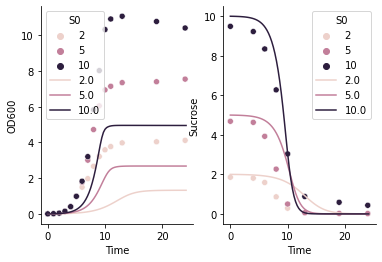

R2 = 0.159 (growth),-7.560 (sucrose)
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 106.0338
Function value obtained: 23.3657
Current minimum: 23.3657
Iteration No: 2 started. Evaluating function at random point.
mu: 5.582e-04,rho: 2.260e+02,ksuc: 1.203e+00, m 1.395e-08


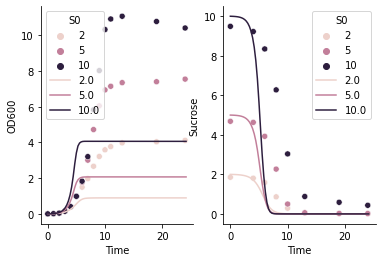

R2 = 0.102 (growth),-5.724 (sucrose)
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 113.3670
Function value obtained: 25.6176
Current minimum: 23.3657
Iteration No: 3 started. Evaluating function at random point.
mu: 9.277e-04,rho: 3.020e+02,ksuc: 1.066e+01, m 7.085e-08


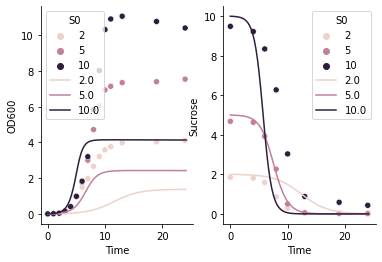

R2 = 0.151 (growth),-5.781 (sucrose)
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 88.1721
Function value obtained: 24.3212
Current minimum: 23.3657
Iteration No: 4 started. Evaluating function at random point.
mu: 2.531e-04,rho: 2.150e+02,ksuc: 9.720e+00, m 2.774e-08


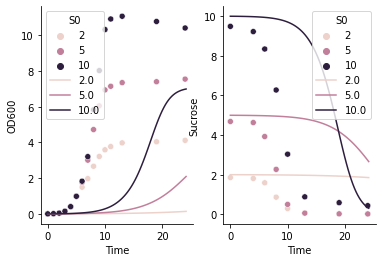

R2 = -0.659 (growth),-16.336 (sucrose)
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 78.7666
Function value obtained: 28.9776
Current minimum: 23.3657
Iteration No: 5 started. Evaluating function at random point.
mu: 8.451e-04,rho: 2.450e+02,ksuc: 7.794e+00, m 5.317e-08


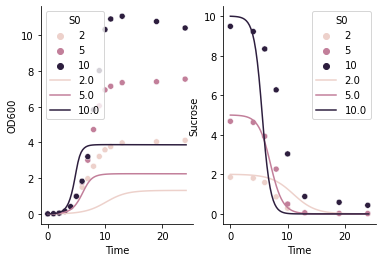

R2 = 0.129 (growth),-5.713 (sucrose)
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 93.7856
Function value obtained: 24.5882
Current minimum: 23.3657
Iteration No: 6 started. Evaluating function at random point.
mu: 5.790e-04,rho: 2.220e+02,ksuc: 7.788e+00, m 2.544e-08


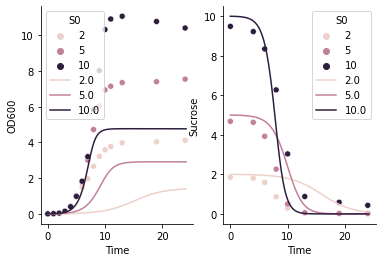

R2 = 0.179 (growth),-6.734 (sucrose)
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 120.7277
Function value obtained: 23.6073
Current minimum: 23.3657
Iteration No: 7 started. Evaluating function at random point.
mu: 6.118e-04,rho: 1.990e+02,ksuc: 1.802e+00, m 5.284e-08


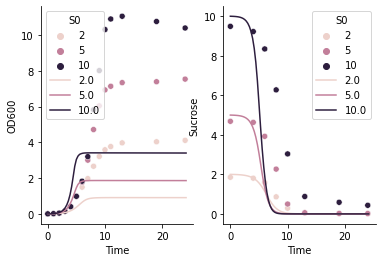

R2 = 0.021 (growth),-5.657 (sucrose)
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 110.8404
Function value obtained: 26.0567
Current minimum: 23.3657
Iteration No: 8 started. Evaluating function at random point.
mu: 3.800e-04,rho: 1.810e+02,ksuc: 1.384e+01, m 4.034e-09


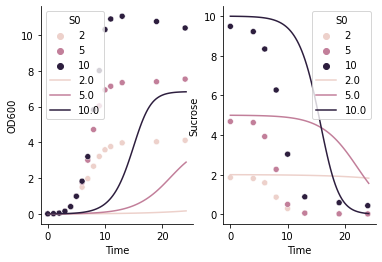

R2 = -0.537 (growth),-14.997 (sucrose)
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 116.6988
Function value obtained: 28.2586
Current minimum: 23.3657
Iteration No: 9 started. Evaluating function at random point.
mu: 9.574e-04,rho: 2.070e+02,ksuc: 7.746e+00, m 7.554e-08


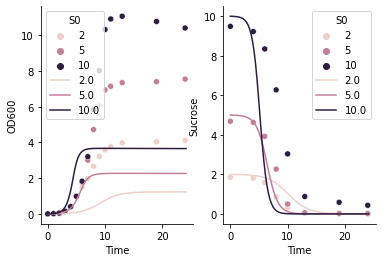

R2 = 0.084 (growth),-5.530 (sucrose)
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 106.7349
Function value obtained: 25.0393
Current minimum: 23.3657
Iteration No: 10 started. Evaluating function at random point.
mu: 2.880e-04,rho: 1.980e+02,ksuc: 1.379e+01, m 6.534e-08


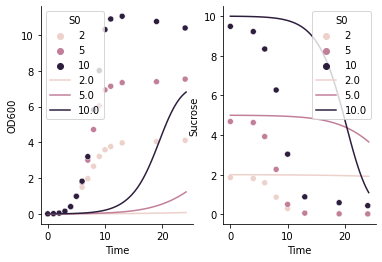

R2 = -0.741 (growth),-17.274 (sucrose)
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 66.3675
Function value obtained: 29.4343
Current minimum: 23.3657
Iteration No: 11 started. Evaluating function at random point.
mu: 3.171e-04,rho: 1.980e+02,ksuc: 6.015e+00, m 8.360e-08


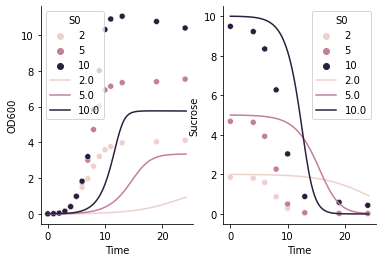

R2 = -0.266 (growth),-12.693 (sucrose)
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 124.0467
Function value obtained: 26.6162
Current minimum: 23.3657
Iteration No: 12 started. Evaluating function at random point.
mu: 7.169e-04,rho: 2.400e+02,ksuc: 4.642e-01, m 6.117e-08


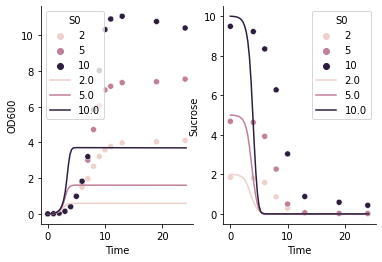

R2 = -0.076 (growth),-5.029 (sucrose)
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 100.1690
Function value obtained: 27.3257
Current minimum: 23.3657
Iteration No: 13 started. Evaluating function at random point.
mu: 6.055e-04,rho: 1.640e+02,ksuc: 1.320e+01, m 3.001e-08


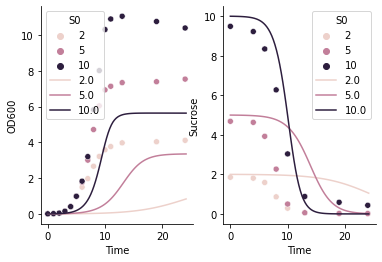

R2 = 0.023 (growth),-9.057 (sucrose)
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 160.0553
Function value obtained: 24.3486
Current minimum: 23.3657
Iteration No: 14 started. Evaluating function at random point.
mu: 6.286e-04,rho: 2.030e+02,ksuc: 7.733e+00, m 2.588e-09


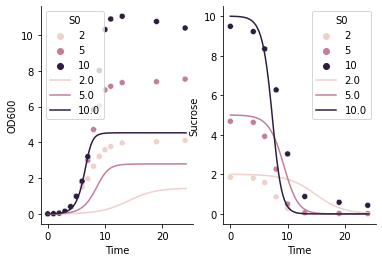

R2 = 0.177 (growth),-6.560 (sucrose)
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 120.6054
Function value obtained: 23.7627
Current minimum: 23.3657
Iteration No: 15 started. Evaluating function at random point.
mu: 8.860e-05,rho: 2.560e+02,ksuc: 7.029e+00, m 8.931e-08


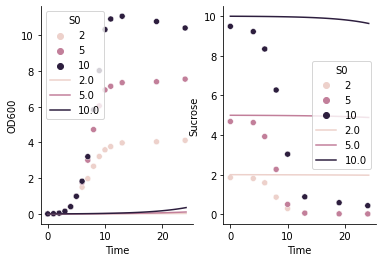

R2 = -1.292 (growth),-23.201 (sucrose)
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 11.7787
Function value obtained: 32.0538
Current minimum: 23.3657
Iteration No: 16 started. Evaluating function at random point.
mu: 6.166e-04,rho: 3.040e+02,ksuc: 1.220e+01, m 9.752e-08


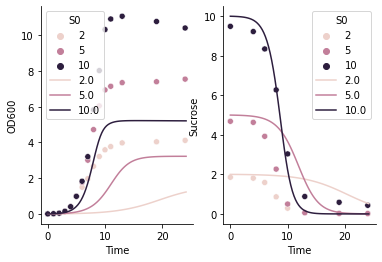

R2 = 0.146 (growth),-7.255 (sucrose)
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 84.1588
Function value obtained: 23.5826
Current minimum: 23.3657
Iteration No: 17 started. Evaluating function at random point.
mu: 8.902e-04,rho: 2.250e+02,ksuc: 2.864e+00, m 3.241e-08


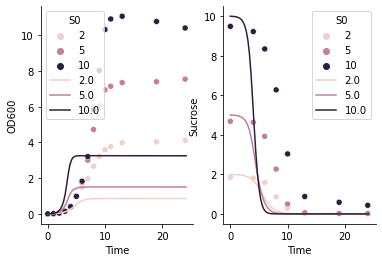

R2 = -0.051 (growth),-5.012 (sucrose)
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 90.0613
Function value obtained: 26.9330
Current minimum: 23.3657
Iteration No: 18 started. Evaluating function at random point.
mu: 6.594e-04,rho: 2.210e+02,ksuc: 1.032e+01, m 2.216e-08


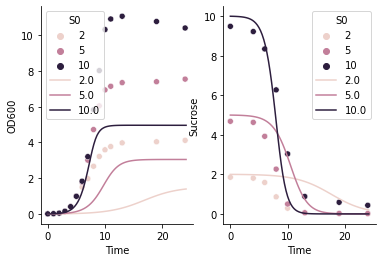

R2 = 0.178 (growth),-6.802 (sucrose)
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 115.9337
Function value obtained: 23.5525
Current minimum: 23.3657
Iteration No: 19 started. Evaluating function at random point.
mu: 4.436e-04,rho: 1.510e+02,ksuc: 9.557e+00, m 8.869e-08


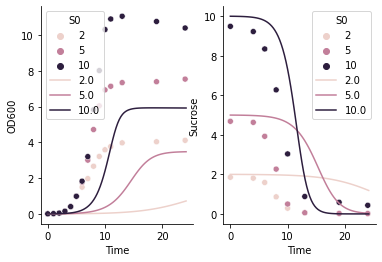

R2 = -0.146 (growth),-11.483 (sucrose)
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 168.3170
Function value obtained: 25.7290
Current minimum: 23.3657
Iteration No: 20 started. Evaluating function at random point.
mu: 6.228e-04,rho: 1.640e+02,ksuc: 1.193e+01, m 5.941e-08


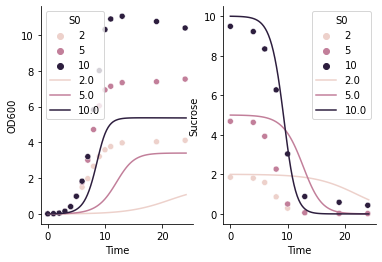

R2 = 0.082 (growth),-7.911 (sucrose)
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 160.0697
Function value obtained: 23.8989
Current minimum: 23.3657
Iteration No: 21 started. Searching for the next optimal point.
mu: 3.094e-04,rho: 3.070e+02,ksuc: 1.000e-01, m 1.000e-09


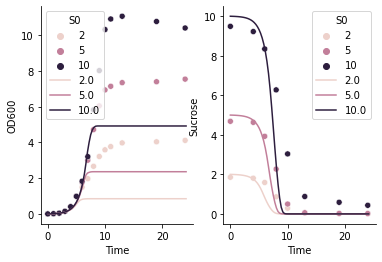

R2 = 0.292 (growth),-6.159 (sucrose)
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 86.1816
Function value obtained: 23.5312
Current minimum: 23.3657
Iteration No: 22 started. Searching for the next optimal point.
mu: 3.172e-04,rho: 2.410e+02,ksuc: 2.170e+00, m 2.686e-08


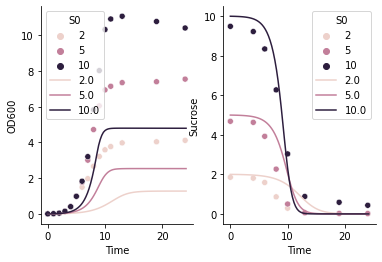

R2 = 0.183 (growth),-7.200 (sucrose)
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 99.2287
Function value obtained: 23.2614
Current minimum: 23.2614
Iteration No: 23 started. Searching for the next optimal point.
mu: 8.344e-04,rho: 3.070e+02,ksuc: 1.500e+01, m 1.000e-07


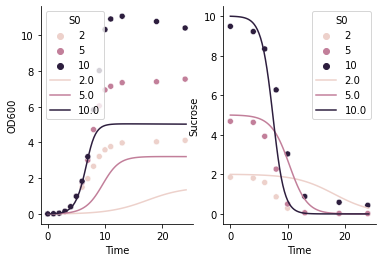

R2 = 0.201 (growth),-6.605 (sucrose)
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 92.5099
Function value obtained: 23.5107
Current minimum: 23.2614
Iteration No: 24 started. Searching for the next optimal point.
mu: 3.204e-04,rho: 2.490e+02,ksuc: 1.904e+00, m 1.959e-08


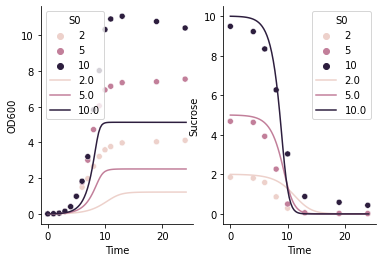

R2 = 0.259 (growth),-6.862 (sucrose)
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 109.3963
Function value obtained: 22.7799
Current minimum: 22.7799
Iteration No: 25 started. Searching for the next optimal point.
mu: 3.611e-04,rho: 3.070e+02,ksuc: 1.744e+00, m 1.000e-09


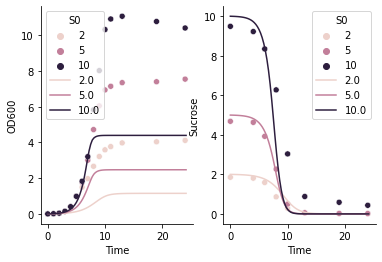

R2 = 0.252 (growth),-6.416 (sucrose)
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 82.6795
Function value obtained: 23.3879
Current minimum: 22.7799
Iteration No: 26 started. Searching for the next optimal point.
mu: 2.912e-04,rho: 1.500e+02,ksuc: 1.165e+00, m 1.000e-07


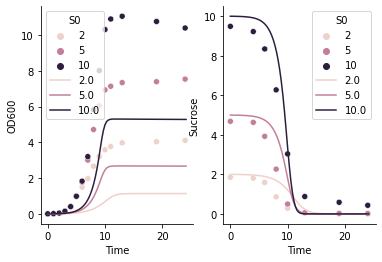

R2 = 0.198 (growth),-7.692 (sucrose)
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 172.6483
Function value obtained: 23.0179
Current minimum: 22.7799
Iteration No: 27 started. Searching for the next optimal point.
mu: 7.589e-04,rho: 3.070e+02,ksuc: 1.267e+01, m 1.000e-07


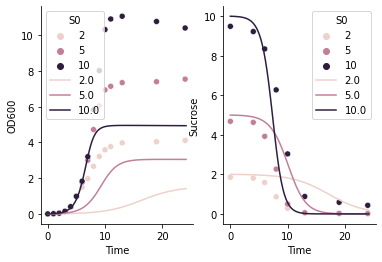

R2 = 0.204 (growth),-6.569 (sucrose)
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 87.2948
Function value obtained: 23.5193
Current minimum: 22.7799
Iteration No: 28 started. Searching for the next optimal point.
mu: 1.000e-03,rho: 3.070e+02,ksuc: 1.500e+01, m 1.000e-07


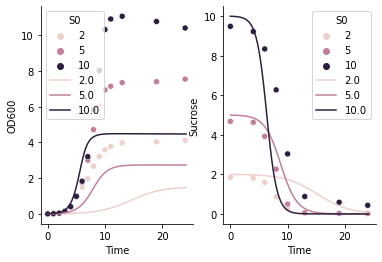

R2 = 0.173 (growth),-6.128 (sucrose)
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 83.8397
Function value obtained: 23.9833
Current minimum: 22.7799
Iteration No: 29 started. Searching for the next optimal point.
mu: 1.756e-04,rho: 1.500e+02,ksuc: 1.000e-01, m 1.000e-09


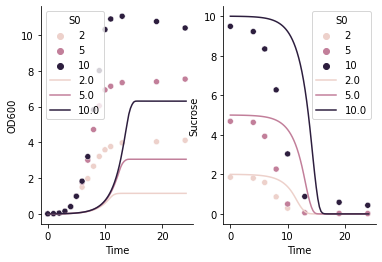

R2 = -0.280 (growth),-13.784 (sucrose)
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 158.2622
Function value obtained: 26.8929
Current minimum: 22.7799
Iteration No: 30 started. Searching for the next optimal point.
mu: 3.349e-04,rho: 1.500e+02,ksuc: 1.164e+00, m 1.000e-07


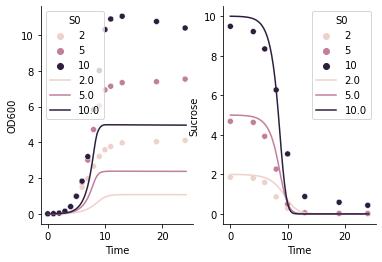

R2 = 0.265 (growth),-6.740 (sucrose)
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 169.4117
Function value obtained: 22.8913
Current minimum: 22.7799
Iteration No: 31 started. Searching for the next optimal point.
mu: 3.336e-04,rho: 1.500e+02,ksuc: 1.220e+00, m 1.000e-07


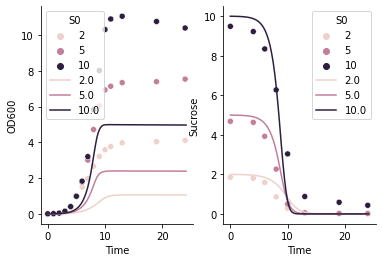

R2 = 0.256 (growth),-6.769 (sucrose)
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 171.4608
Function value obtained: 22.9172
Current minimum: 22.7799
Iteration No: 32 started. Searching for the next optimal point.
mu: 3.306e-04,rho: 1.500e+02,ksuc: 1.256e+00, m 1.000e-09


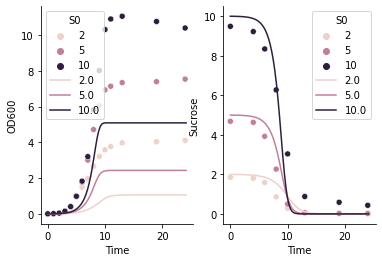

R2 = 0.258 (growth),-6.801 (sucrose)
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 169.9861
Function value obtained: 22.8448
Current minimum: 22.7799
Iteration No: 33 started. Searching for the next optimal point.
mu: 3.281e-04,rho: 1.500e+02,ksuc: 1.282e+00, m 1.000e-09


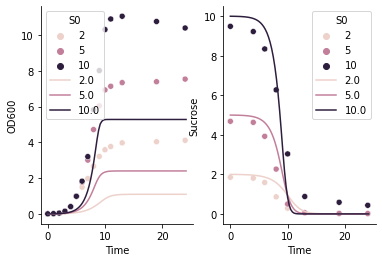

R2 = 0.270 (growth),-6.830 (sucrose)
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 182.6755
Function value obtained: 22.6840
Current minimum: 22.6840
Iteration No: 34 started. Searching for the next optimal point.
mu: 7.193e-04,rho: 3.070e+02,ksuc: 1.500e+01, m 1.000e-07


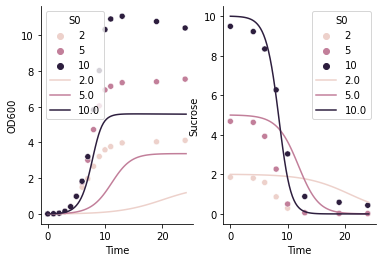

R2 = 0.194 (growth),-7.092 (sucrose)
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 96.6964
Function value obtained: 23.2528
Current minimum: 22.6840
Iteration No: 35 started. Searching for the next optimal point.
mu: 3.370e-04,rho: 1.500e+02,ksuc: 1.114e+00, m 1.000e-09


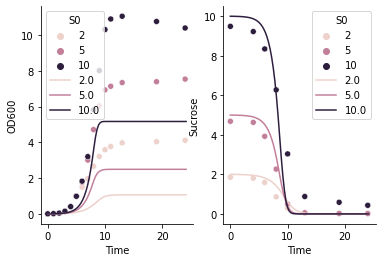

R2 = 0.291 (growth),-6.711 (sucrose)
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 178.2762
Function value obtained: 22.7236
Current minimum: 22.6840
Iteration No: 36 started. Searching for the next optimal point.
mu: 3.372e-04,rho: 1.500e+02,ksuc: 1.075e+00, m 1.000e-09


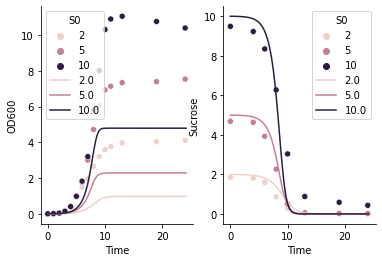

R2 = 0.242 (growth),-6.696 (sucrose)
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 171.7721
Function value obtained: 23.1410
Current minimum: 22.6840
Iteration No: 37 started. Searching for the next optimal point.
mu: 7.697e-04,rho: 1.500e+02,ksuc: 1.500e+01, m 1.000e-09


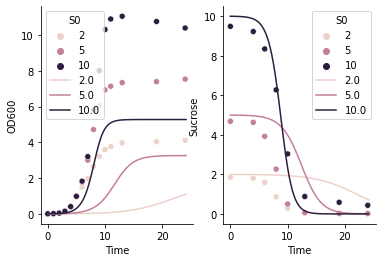

R2 = 0.113 (growth),-7.410 (sucrose)
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 171.9571
Function value obtained: 23.7341
Current minimum: 22.6840
Iteration No: 38 started. Searching for the next optimal point.
mu: 3.485e-04,rho: 1.500e+02,ksuc: 1.741e+00, m 1.000e-07


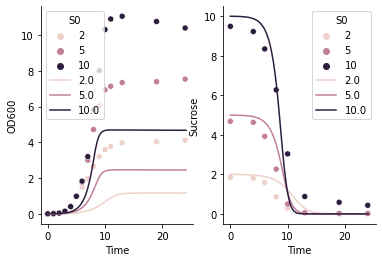

R2 = 0.211 (growth),-6.859 (sucrose)
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 164.5410
Function value obtained: 23.1812
Current minimum: 22.6840
Iteration No: 39 started. Searching for the next optimal point.
mu: 3.570e-04,rho: 1.500e+02,ksuc: 1.000e-01, m 1.000e-09


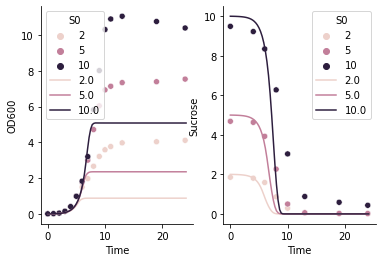

R2 = 0.313 (growth),-6.224 (sucrose)
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 180.3146
Function value obtained: 23.4133
Current minimum: 22.6840
Iteration No: 40 started. Searching for the next optimal point.
mu: 1.000e-03,rho: 3.070e+02,ksuc: 1.000e-01, m 4.666e-08


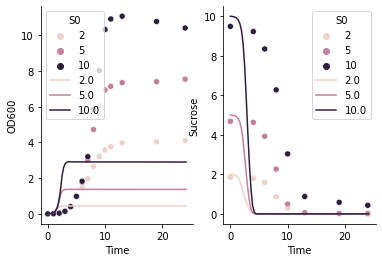

R2 = -0.229 (growth),-5.358 (sucrose)
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 62.9156
Function value obtained: 30.0391
Current minimum: 22.6840
Iteration No: 41 started. Searching for the next optimal point.
mu: 5.933e-04,rho: 3.070e+02,ksuc: 9.622e+00, m 1.000e-07


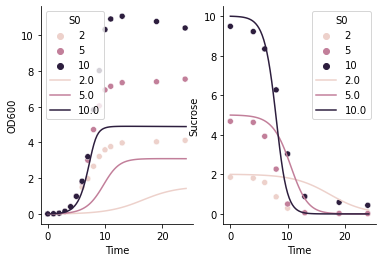

R2 = 0.180 (growth),-6.798 (sucrose)
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 85.7126
Function value obtained: 23.5383
Current minimum: 22.6840
Iteration No: 42 started. Searching for the next optimal point.
mu: 5.125e-04,rho: 3.070e+02,ksuc: 5.362e+00, m 1.000e-09


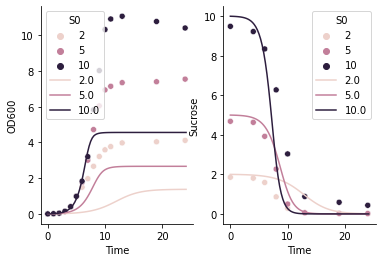

R2 = 0.223 (growth),-6.417 (sucrose)
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 87.7557
Function value obtained: 23.5068
Current minimum: 22.6840
Iteration No: 43 started. Searching for the next optimal point.
mu: 9.177e-04,rho: 1.500e+02,ksuc: 1.500e+01, m 1.000e-07


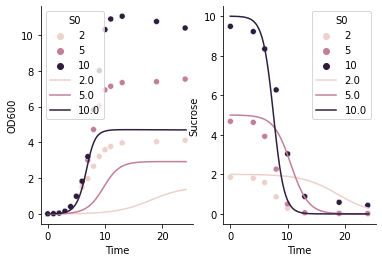

R2 = 0.143 (growth),-6.738 (sucrose)
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 173.1443
Function value obtained: 23.8954
Current minimum: 22.6840
Iteration No: 44 started. Searching for the next optimal point.
mu: 1.000e-03,rho: 1.500e+02,ksuc: 1.225e+01, m 1.000e-07


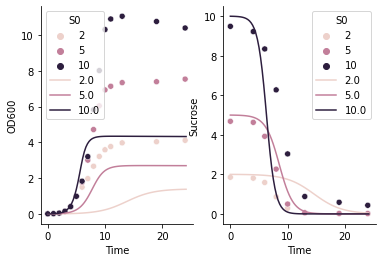

R2 = 0.152 (growth),-6.180 (sucrose)
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 168.2351
Function value obtained: 24.1772
Current minimum: 22.6840
Iteration No: 45 started. Searching for the next optimal point.
mu: 4.405e-04,rho: 1.500e+02,ksuc: 3.399e+00, m 1.000e-09


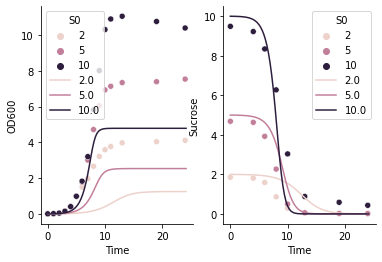

R2 = 0.226 (growth),-6.728 (sucrose)
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 167.9609
Function value obtained: 23.2478
Current minimum: 22.6840
Iteration No: 46 started. Searching for the next optimal point.
mu: 7.234e-04,rho: 3.070e+02,ksuc: 9.636e+00, m 1.000e-07


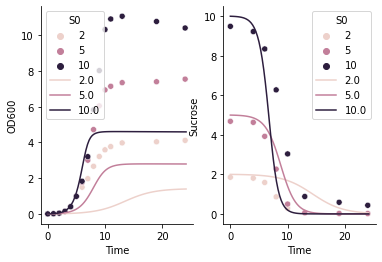

R2 = 0.200 (growth),-6.272 (sucrose)
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 87.1777
Function value obtained: 23.7341
Current minimum: 22.6840
Iteration No: 47 started. Searching for the next optimal point.
mu: 6.619e-04,rho: 3.070e+02,ksuc: 1.500e+01, m 1.000e-09


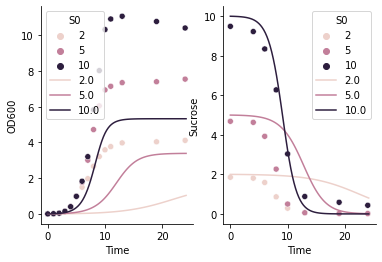

R2 = 0.103 (growth),-7.754 (sucrose)
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 83.0359
Function value obtained: 23.8317
Current minimum: 22.6840
Iteration No: 48 started. Searching for the next optimal point.
mu: 3.222e-04,rho: 1.500e+02,ksuc: 1.349e+00, m 1.000e-09


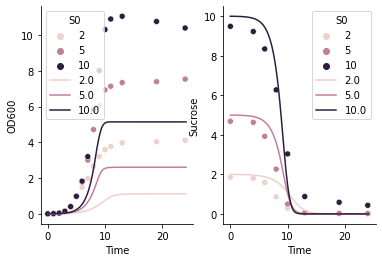

R2 = 0.240 (growth),-6.951 (sucrose)
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 175.3364
Function value obtained: 22.8442
Current minimum: 22.6840
Iteration No: 49 started. Searching for the next optimal point.
mu: 3.207e-04,rho: 1.500e+02,ksuc: 1.333e+00, m 1.000e-09


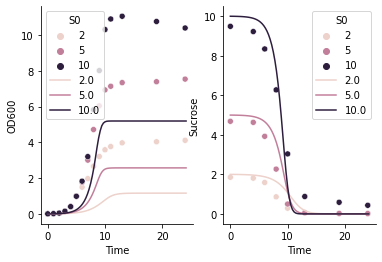

R2 = 0.250 (growth),-6.943 (sucrose)
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 174.5161
Function value obtained: 22.7610
Current minimum: 22.6840
Iteration No: 50 started. Searching for the next optimal point.
mu: 3.187e-04,rho: 1.500e+02,ksuc: 1.314e+00, m 1.000e-09


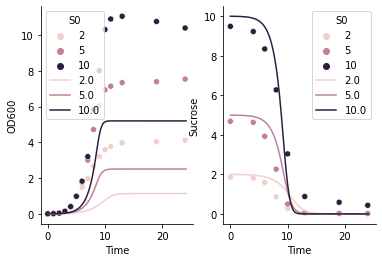

R2 = 0.246 (growth),-6.969 (sucrose)
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 171.5541
Function value obtained: 22.7763
Current minimum: 22.6840
Iteration No: 51 started. Searching for the next optimal point.
mu: 3.173e-04,rho: 1.500e+02,ksuc: 1.316e+00, m 1.000e-09


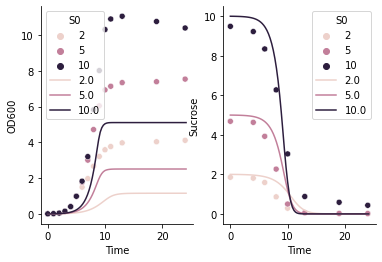

R2 = 0.236 (growth),-7.000 (sucrose)
Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 170.4578
Function value obtained: 22.8507
Current minimum: 22.6840
Iteration No: 52 started. Searching for the next optimal point.
mu: 3.176e-04,rho: 1.500e+02,ksuc: 1.316e+00, m 1.000e-09


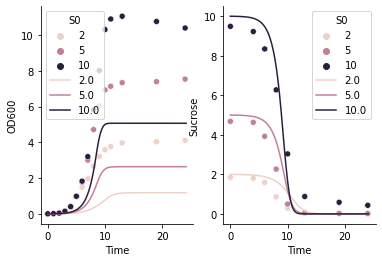

R2 = 0.237 (growth),-7.004 (sucrose)
Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 174.9254
Function value obtained: 22.8517
Current minimum: 22.6840
Iteration No: 53 started. Searching for the next optimal point.
mu: 3.178e-04,rho: 1.500e+02,ksuc: 1.317e+00, m 1.000e-09


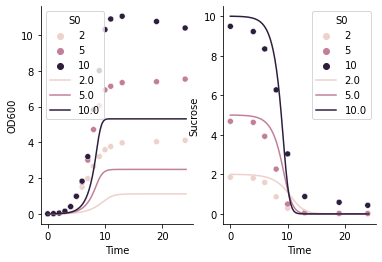

R2 = 0.253 (growth),-6.961 (sucrose)
Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 182.3905
Function value obtained: 22.7118
Current minimum: 22.6840
Iteration No: 54 started. Searching for the next optimal point.
mu: 3.167e-04,rho: 1.500e+02,ksuc: 1.316e+00, m 1.000e-09


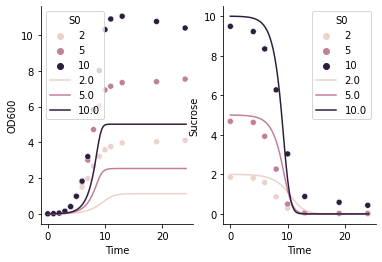

R2 = 0.221 (growth),-7.027 (sucrose)
Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 171.3651
Function value obtained: 22.9658
Current minimum: 22.6840
Iteration No: 55 started. Searching for the next optimal point.
mu: 3.192e-04,rho: 1.500e+02,ksuc: 1.331e+00, m 1.000e-09


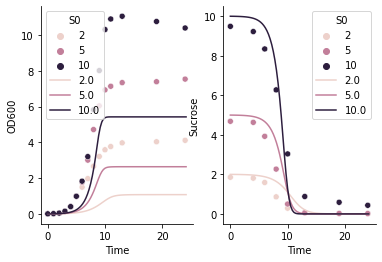

R2 = 0.259 (growth),-6.934 (sucrose)
Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 182.9803
Function value obtained: 22.6649
Current minimum: 22.6649
Iteration No: 56 started. Searching for the next optimal point.
mu: 3.184e-04,rho: 1.500e+02,ksuc: 1.337e+00, m 1.000e-09


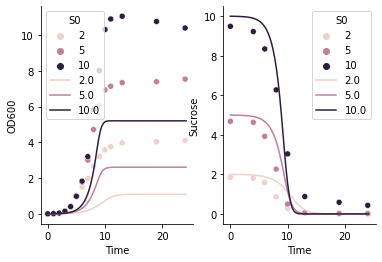

R2 = 0.238 (growth),-6.982 (sucrose)
Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 176.0168
Function value obtained: 22.8320
Current minimum: 22.6649
Iteration No: 57 started. Searching for the next optimal point.
mu: 3.184e-04,rho: 1.500e+02,ksuc: 1.333e+00, m 1.000e-09


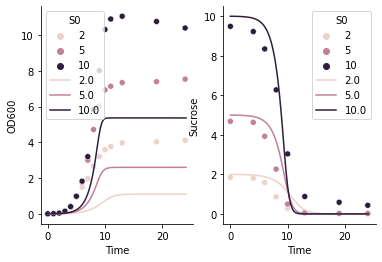

R2 = 0.253 (growth),-6.958 (sucrose)
Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 185.4392
Function value obtained: 22.7001
Current minimum: 22.6649
Iteration No: 58 started. Searching for the next optimal point.
mu: 3.175e-04,rho: 1.500e+02,ksuc: 1.330e+00, m 1.000e-09


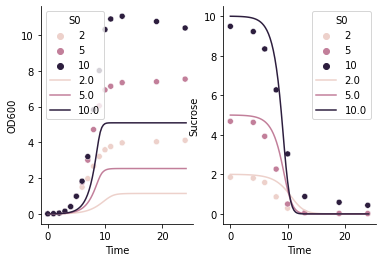

R2 = 0.234 (growth),-7.004 (sucrose)
Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 170.5225
Function value obtained: 22.8675
Current minimum: 22.6649
Iteration No: 59 started. Searching for the next optimal point.
mu: 3.182e-04,rho: 1.500e+02,ksuc: 1.334e+00, m 1.000e-09


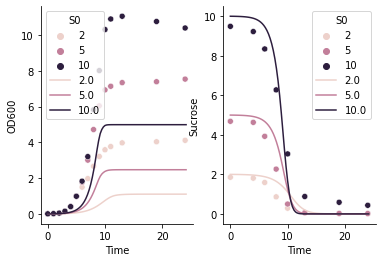

R2 = 0.219 (growth),-7.010 (sucrose)
Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 167.6387
Function value obtained: 22.9925
Current minimum: 22.6649
Iteration No: 60 started. Searching for the next optimal point.
mu: 3.211e-04,rho: 1.500e+02,ksuc: 1.368e+00, m 1.000e-09


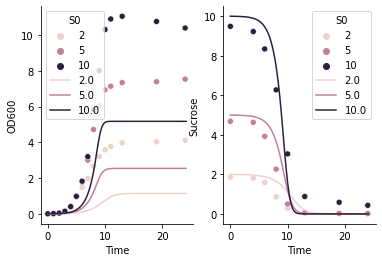

R2 = 0.238 (growth),-6.990 (sucrose)
Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 171.7515
Function value obtained: 22.8247
Current minimum: 22.6649
Iteration No: 61 started. Searching for the next optimal point.
mu: 3.201e-04,rho: 1.500e+02,ksuc: 1.345e+00, m 1.000e-09


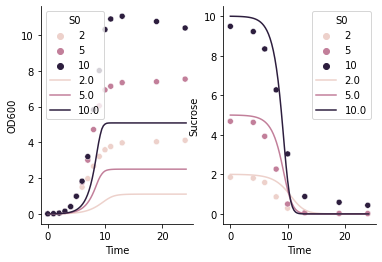

R2 = 0.224 (growth),-7.012 (sucrose)
Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 174.3423
Function value obtained: 22.9398
Current minimum: 22.6649
Iteration No: 62 started. Searching for the next optimal point.
mu: 3.270e-04,rho: 1.500e+02,ksuc: 1.444e+00, m 1.000e-09


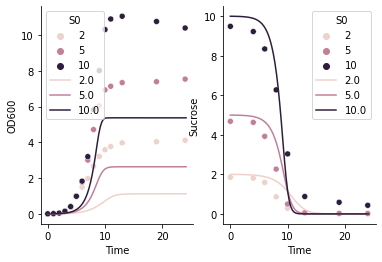

R2 = 0.262 (growth),-6.909 (sucrose)
Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 185.5884
Function value obtained: 22.6625
Current minimum: 22.6625
Iteration No: 63 started. Searching for the next optimal point.
mu: 3.267e-04,rho: 1.500e+02,ksuc: 1.491e+00, m 1.000e-09


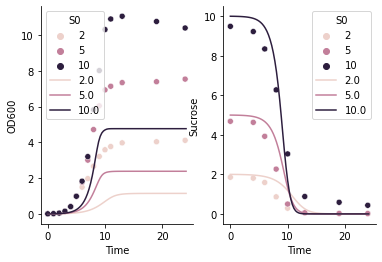

R2 = 0.199 (growth),-7.013 (sucrose)
Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 166.3199
Function value obtained: 23.1690
Current minimum: 22.6625
Iteration No: 64 started. Searching for the next optimal point.
mu: 3.201e-04,rho: 1.500e+02,ksuc: 1.238e+00, m 1.000e-07


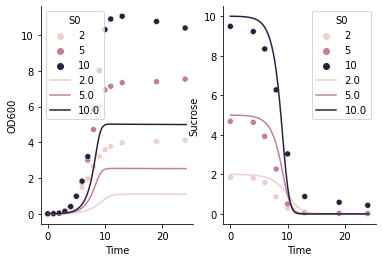

R2 = 0.234 (growth),-6.921 (sucrose)
Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 177.0620
Function value obtained: 22.9258
Current minimum: 22.6625
Iteration No: 65 started. Searching for the next optimal point.
mu: 3.181e-04,rho: 1.500e+02,ksuc: 1.219e+00, m 1.000e-09


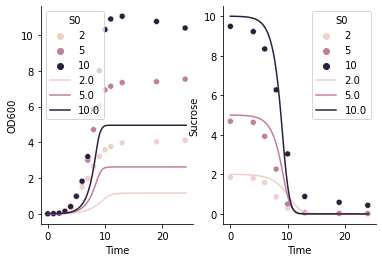

R2 = 0.238 (growth),-6.935 (sucrose)
Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 173.9402
Function value obtained: 22.8978
Current minimum: 22.6625
Iteration No: 66 started. Searching for the next optimal point.
mu: 3.191e-04,rho: 1.500e+02,ksuc: 1.249e+00, m 1.000e-09


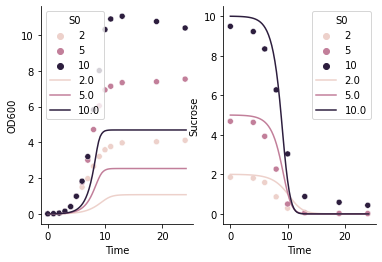

R2 = 0.193 (growth),-6.986 (sucrose)
Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 166.9709
Function value obtained: 23.2438
Current minimum: 22.6625
Iteration No: 67 started. Searching for the next optimal point.
mu: 3.275e-04,rho: 1.500e+02,ksuc: 1.372e+00, m 1.000e-07


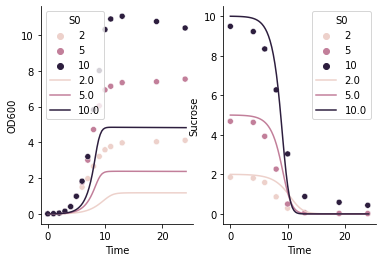

R2 = 0.225 (growth),-6.932 (sucrose)
Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 163.8603
Function value obtained: 23.0097
Current minimum: 22.6625
Iteration No: 68 started. Searching for the next optimal point.
mu: 3.344e-04,rho: 1.500e+02,ksuc: 1.549e+00, m 1.000e-09


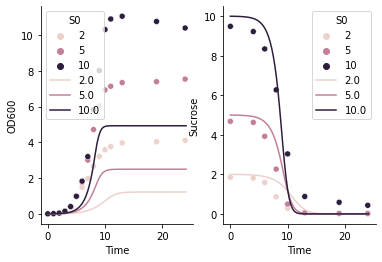

R2 = 0.238 (growth),-6.906 (sucrose)
Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 170.0811
Function value obtained: 22.9142
Current minimum: 22.6625
Iteration No: 69 started. Searching for the next optimal point.
mu: 3.320e-04,rho: 1.500e+02,ksuc: 1.504e+00, m 1.000e-09


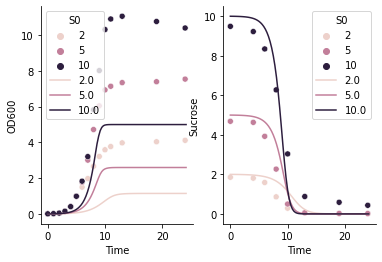

R2 = 0.236 (growth),-6.903 (sucrose)
Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 170.8374
Function value obtained: 22.9214
Current minimum: 22.6625
Iteration No: 70 started. Searching for the next optimal point.
mu: 3.293e-04,rho: 1.500e+02,ksuc: 1.433e+00, m 1.000e-09


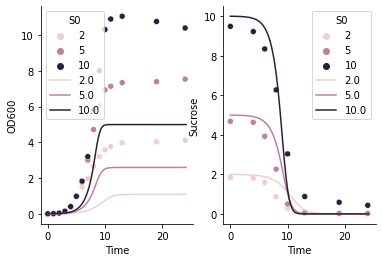

R2 = 0.232 (growth),-6.902 (sucrose)
Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 167.1010
Function value obtained: 22.9531
Current minimum: 22.6625
Iteration No: 71 started. Searching for the next optimal point.
mu: 3.216e-04,rho: 1.500e+02,ksuc: 1.268e+00, m 1.000e-07


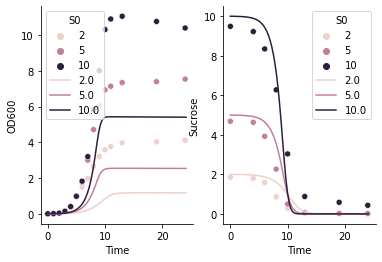

R2 = 0.282 (growth),-6.874 (sucrose)
Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 183.9542
Function value obtained: 22.5291
Current minimum: 22.5291
Iteration No: 72 started. Searching for the next optimal point.
mu: 3.212e-04,rho: 1.500e+02,ksuc: 1.228e+00, m 1.000e-07


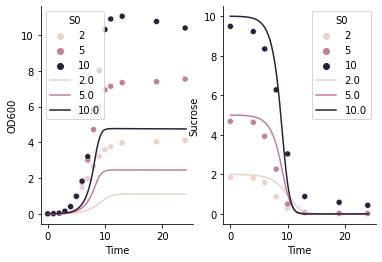

R2 = 0.210 (growth),-6.940 (sucrose)
Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 168.9864
Function value obtained: 23.1348
Current minimum: 22.5291
Iteration No: 73 started. Searching for the next optimal point.
mu: 3.246e-04,rho: 1.500e+02,ksuc: 1.304e+00, m 1.000e-07


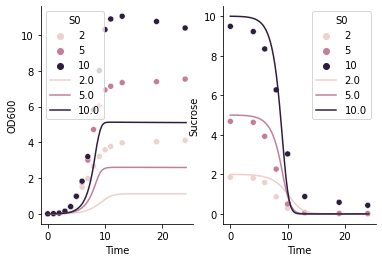

R2 = 0.250 (growth),-6.884 (sucrose)
Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 180.7597
Function value obtained: 22.8188
Current minimum: 22.5291
Iteration No: 74 started. Searching for the next optimal point.
mu: 3.240e-04,rho: 1.500e+02,ksuc: 1.297e+00, m 1.000e-07


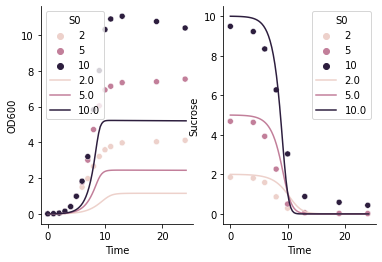

R2 = 0.265 (growth),-6.873 (sucrose)
Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 175.9644
Function value obtained: 22.6944
Current minimum: 22.5291
Iteration No: 75 started. Searching for the next optimal point.
mu: 3.239e-04,rho: 1.500e+02,ksuc: 1.287e+00, m 1.000e-07


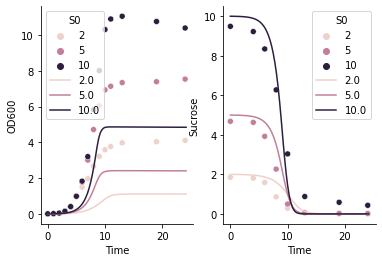

R2 = 0.221 (growth),-6.930 (sucrose)
Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 167.1086
Function value obtained: 23.0391
Current minimum: 22.5291
Iteration No: 76 started. Searching for the next optimal point.
mu: 3.246e-04,rho: 1.500e+02,ksuc: 1.310e+00, m 1.000e-07


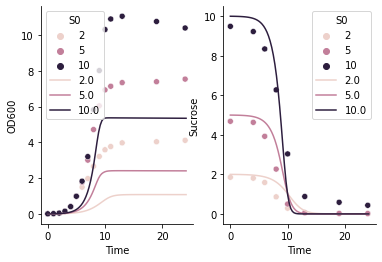

R2 = 0.266 (growth),-6.866 (sucrose)
Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 179.1702
Function value obtained: 22.6682
Current minimum: 22.5291
Iteration No: 77 started. Searching for the next optimal point.
mu: 3.251e-04,rho: 1.500e+02,ksuc: 1.312e+00, m 1.000e-07


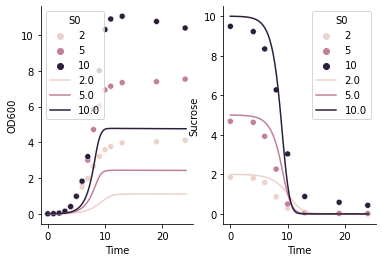

R2 = 0.211 (growth),-6.932 (sucrose)
Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 161.6177
Function value obtained: 23.1276
Current minimum: 22.5291
Iteration No: 78 started. Searching for the next optimal point.
mu: 3.332e-04,rho: 1.500e+02,ksuc: 1.496e+00, m 1.000e-09


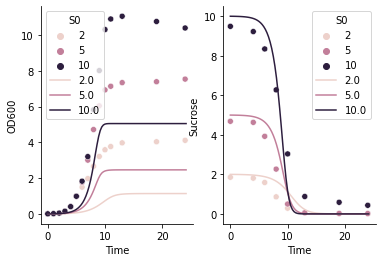

R2 = 0.240 (growth),-6.891 (sucrose)
Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 174.9766
Function value obtained: 22.8916
Current minimum: 22.5291
Iteration No: 79 started. Searching for the next optimal point.
mu: 3.312e-04,rho: 1.500e+02,ksuc: 1.460e+00, m 1.000e-09


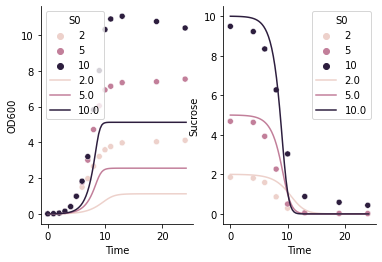

R2 = 0.248 (growth),-6.882 (sucrose)
Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 178.4791
Function value obtained: 22.8306
Current minimum: 22.5291
Iteration No: 80 started. Searching for the next optimal point.
mu: 3.202e-04,rho: 1.500e+02,ksuc: 1.215e+00, m 1.000e-09


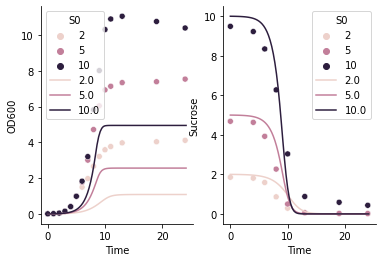

R2 = 0.229 (growth),-6.907 (sucrose)
Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 169.4680
Function value obtained: 22.9810
Current minimum: 22.5291
Iteration No: 81 started. Searching for the next optimal point.
mu: 3.328e-04,rho: 1.500e+02,ksuc: 1.505e+00, m 1.000e-09


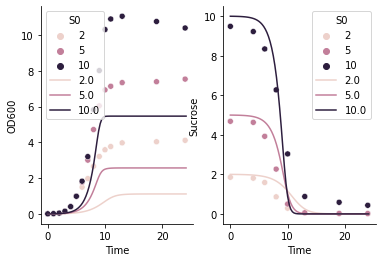

R2 = 0.273 (growth),-6.867 (sucrose)
Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 189.3547
Function value obtained: 22.6007
Current minimum: 22.5291
Iteration No: 82 started. Searching for the next optimal point.
mu: 3.380e-04,rho: 1.500e+02,ksuc: 1.598e+00, m 1.000e-09


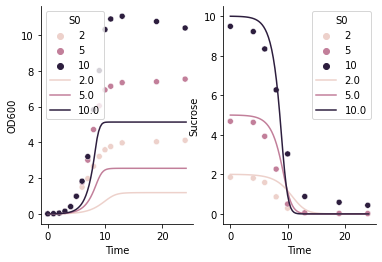

R2 = 0.260 (growth),-6.863 (sucrose)
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 173.0301
Function value obtained: 22.7560
Current minimum: 22.5291
Iteration No: 83 started. Searching for the next optimal point.
mu: 3.398e-04,rho: 1.500e+02,ksuc: 1.631e+00, m 1.000e-09


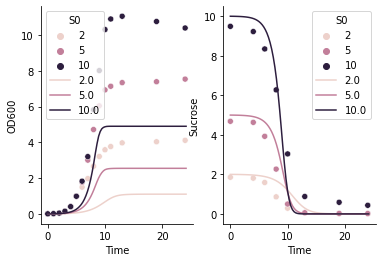

R2 = 0.220 (growth),-6.891 (sucrose)
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 171.6699
Function value obtained: 23.0593
Current minimum: 22.5291
Iteration No: 84 started. Searching for the next optimal point.
mu: 3.342e-04,rho: 1.500e+02,ksuc: 1.518e+00, m 1.000e-09


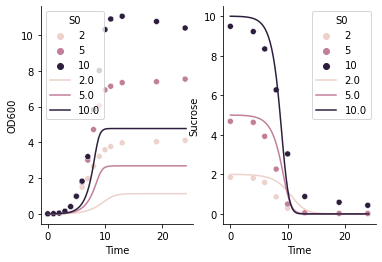

R2 = 0.213 (growth),-6.901 (sucrose)
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 163.3943
Function value obtained: 23.1261
Current minimum: 22.5291
Iteration No: 85 started. Searching for the next optimal point.
mu: 3.257e-04,rho: 1.500e+02,ksuc: 1.327e+00, m 1.000e-07


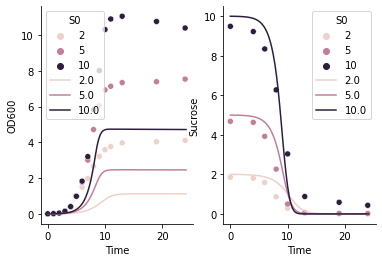

R2 = 0.209 (growth),-6.920 (sucrose)
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 163.8821
Function value obtained: 23.1505
Current minimum: 22.5291
Iteration No: 86 started. Searching for the next optimal point.
mu: 3.203e-04,rho: 1.500e+02,ksuc: 1.208e+00, m 1.000e-09


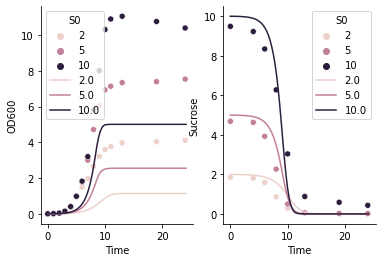

R2 = 0.244 (growth),-6.898 (sucrose)
Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 168.1324
Function value obtained: 22.8677
Current minimum: 22.5291
Iteration No: 87 started. Searching for the next optimal point.
mu: 3.201e-04,rho: 1.500e+02,ksuc: 1.215e+00, m 1.000e-09


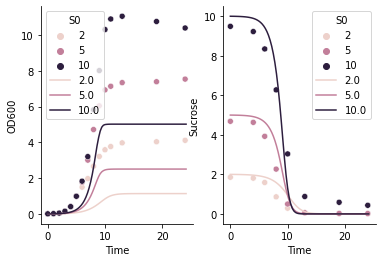

R2 = 0.241 (growth),-6.906 (sucrose)
Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 181.2506
Function value obtained: 22.8857
Current minimum: 22.5291
Iteration No: 88 started. Searching for the next optimal point.
mu: 3.201e-04,rho: 1.500e+02,ksuc: 1.228e+00, m 1.000e-09


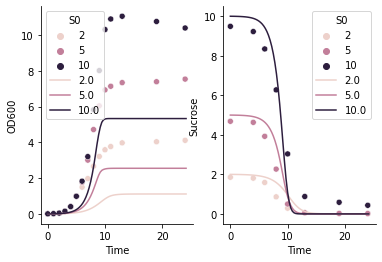

R2 = 0.267 (growth),-6.877 (sucrose)
Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 181.2019
Function value obtained: 22.6600
Current minimum: 22.5291
Iteration No: 89 started. Searching for the next optimal point.
mu: 3.185e-04,rho: 1.500e+02,ksuc: 1.186e+00, m 1.000e-09


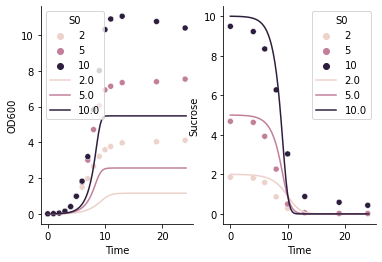

R2 = 0.286 (growth),-6.864 (sucrose)
Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 184.4189
Function value obtained: 22.4922
Current minimum: 22.4922
Iteration No: 90 started. Searching for the next optimal point.
mu: 3.163e-04,rho: 1.500e+02,ksuc: 1.105e+00, m 1.000e-09


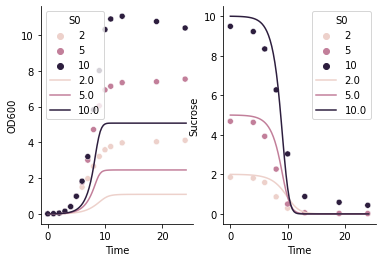

R2 = 0.246 (growth),-6.894 (sucrose)
Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 172.1267
Function value obtained: 22.8598
Current minimum: 22.4922
Iteration No: 91 started. Searching for the next optimal point.
mu: 3.163e-04,rho: 1.500e+02,ksuc: 1.115e+00, m 1.000e-09


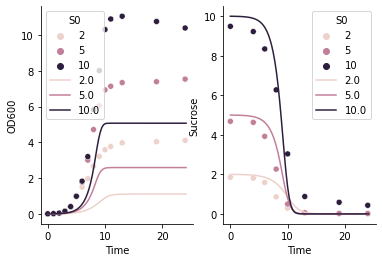

R2 = 0.244 (growth),-6.906 (sucrose)
Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 176.8303
Function value obtained: 22.8587
Current minimum: 22.4922
Iteration No: 92 started. Searching for the next optimal point.
mu: 3.163e-04,rho: 1.500e+02,ksuc: 1.125e+00, m 1.000e-09


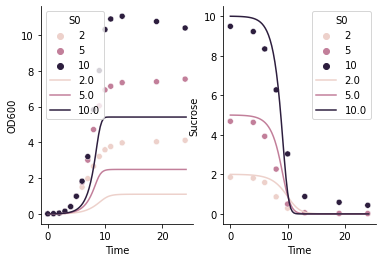

R2 = 0.274 (growth),-6.870 (sucrose)
Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 179.3818
Function value obtained: 22.6016
Current minimum: 22.4922
Iteration No: 93 started. Searching for the next optimal point.
mu: 3.146e-04,rho: 1.500e+02,ksuc: 1.070e+00, m 1.000e-09


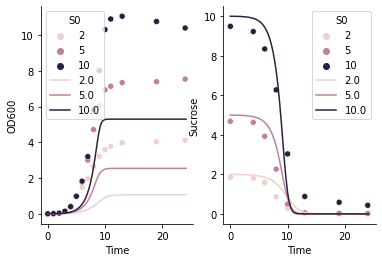

R2 = 0.264 (growth),-6.862 (sucrose)
Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 181.9365
Function value obtained: 22.6991
Current minimum: 22.4922
Iteration No: 94 started. Searching for the next optimal point.
mu: 3.136e-04,rho: 1.500e+02,ksuc: 1.038e+00, m 1.000e-09


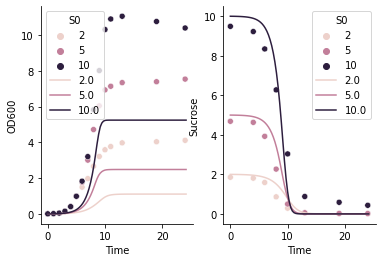

R2 = 0.266 (growth),-6.862 (sucrose)
Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 176.5933
Function value obtained: 22.6927
Current minimum: 22.4922
Iteration No: 95 started. Searching for the next optimal point.
mu: 3.125e-04,rho: 1.500e+02,ksuc: 1.002e+00, m 1.000e-09


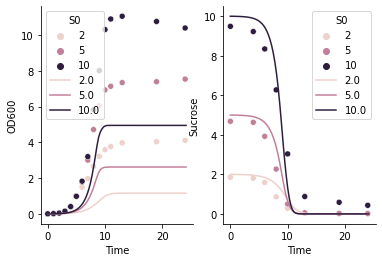

R2 = 0.248 (growth),-6.886 (sucrose)
Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 168.2792
Function value obtained: 22.8656
Current minimum: 22.4922
Iteration No: 96 started. Searching for the next optimal point.
mu: 3.127e-04,rho: 1.500e+02,ksuc: 1.021e+00, m 1.000e-09


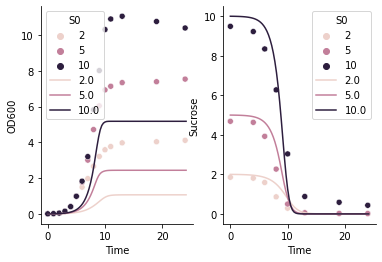

R2 = 0.253 (growth),-6.882 (sucrose)
Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 179.3185
Function value obtained: 22.7929
Current minimum: 22.4922
Iteration No: 97 started. Searching for the next optimal point.
mu: 3.124e-04,rho: 1.500e+02,ksuc: 1.019e+00, m 1.000e-09


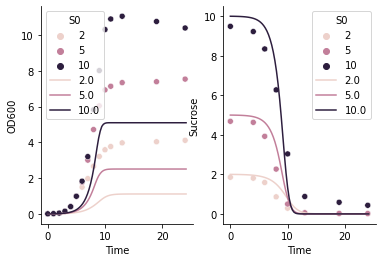

R2 = 0.249 (growth),-6.896 (sucrose)
Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 171.2913
Function value obtained: 22.8216
Current minimum: 22.4922
Iteration No: 98 started. Searching for the next optimal point.
mu: 3.124e-04,rho: 1.500e+02,ksuc: 1.025e+00, m 1.000e-09


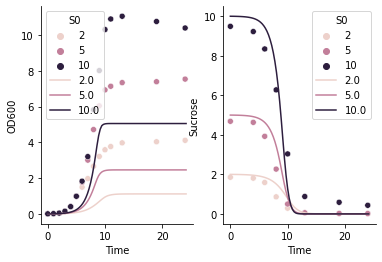

R2 = 0.249 (growth),-6.888 (sucrose)
Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 177.4901
Function value obtained: 22.8322
Current minimum: 22.4922
Iteration No: 99 started. Searching for the next optimal point.
mu: 3.124e-04,rho: 1.500e+02,ksuc: 1.035e+00, m 1.000e-09


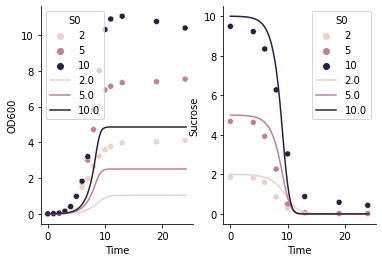

R2 = 0.216 (growth),-6.923 (sucrose)
Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 163.3060
Function value obtained: 23.0899
Current minimum: 22.4922
Iteration No: 100 started. Searching for the next optimal point.
mu: 3.146e-04,rho: 1.500e+02,ksuc: 1.096e+00, m 1.000e-09


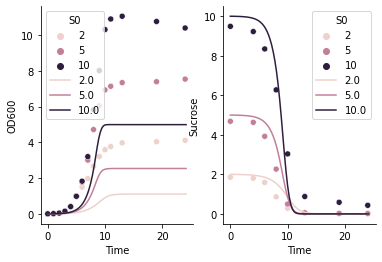

R2 = 0.236 (growth),-6.918 (sucrose)
Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 170.2347
Function value obtained: 22.9188
Current minimum: 22.4922
Iteration No: 101 started. Searching for the next optimal point.
mu: 3.151e-04,rho: 1.500e+02,ksuc: 1.120e+00, m 1.000e-09


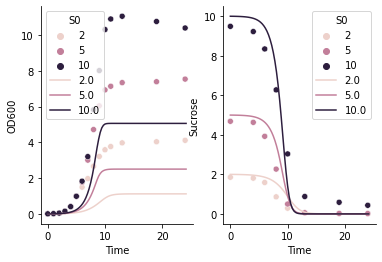

R2 = 0.242 (growth),-6.921 (sucrose)
Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 175.6047
Function value obtained: 22.8644
Current minimum: 22.4922
Iteration No: 102 started. Searching for the next optimal point.
mu: 3.152e-04,rho: 1.500e+02,ksuc: 1.135e+00, m 1.000e-09


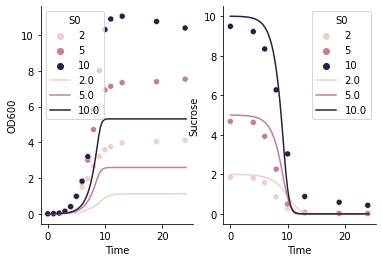

R2 = 0.264 (growth),-6.902 (sucrose)
Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 184.7756
Function value obtained: 22.6616
Current minimum: 22.4922
Iteration No: 103 started. Searching for the next optimal point.
mu: 3.141e-04,rho: 1.500e+02,ksuc: 1.117e+00, m 1.000e-09


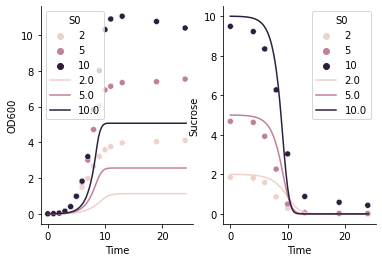

R2 = 0.248 (growth),-6.911 (sucrose)
Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 173.0613
Function value obtained: 22.8209
Current minimum: 22.4922
Iteration No: 104 started. Searching for the next optimal point.
mu: 3.139e-04,rho: 1.500e+02,ksuc: 1.126e+00, m 1.000e-09


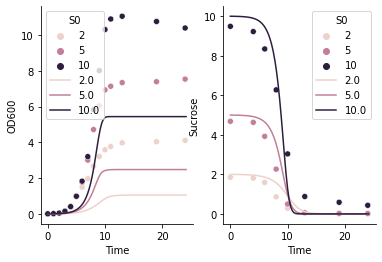

R2 = 0.264 (growth),-6.906 (sucrose)
Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 185.3590
Function value obtained: 22.6506
Current minimum: 22.4922
Iteration No: 105 started. Searching for the next optimal point.
mu: 3.128e-04,rho: 1.500e+02,ksuc: 1.114e+00, m 1.000e-09


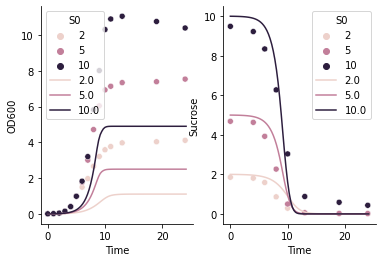

R2 = 0.222 (growth),-6.969 (sucrose)
Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 166.8841
Function value obtained: 23.0135
Current minimum: 22.4922
Iteration No: 106 started. Searching for the next optimal point.
mu: 3.147e-04,rho: 1.500e+02,ksuc: 1.118e+00, m 1.000e-09


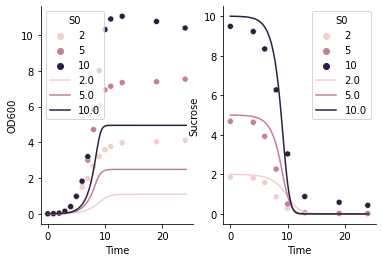

R2 = 0.227 (growth),-6.946 (sucrose)
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 168.7923
Function value obtained: 22.9794
Current minimum: 22.4922
Iteration No: 107 started. Searching for the next optimal point.
mu: 3.157e-04,rho: 1.500e+02,ksuc: 1.145e+00, m 1.000e-09


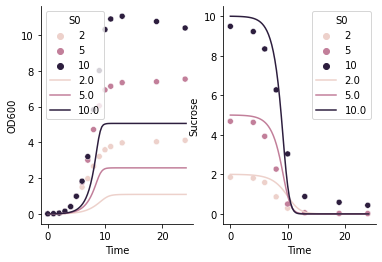

R2 = 0.238 (growth),-6.932 (sucrose)
Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 179.5803
Function value obtained: 22.8890
Current minimum: 22.4922
Iteration No: 108 started. Searching for the next optimal point.
mu: 3.156e-04,rho: 1.500e+02,ksuc: 1.181e+00, m 1.000e-09


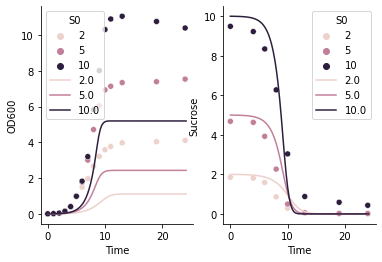

R2 = 0.253 (growth),-6.925 (sucrose)
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 174.9324
Function value obtained: 22.7554
Current minimum: 22.4922
Iteration No: 109 started. Searching for the next optimal point.
mu: 3.145e-04,rho: 1.500e+02,ksuc: 1.210e+00, m 1.000e-09


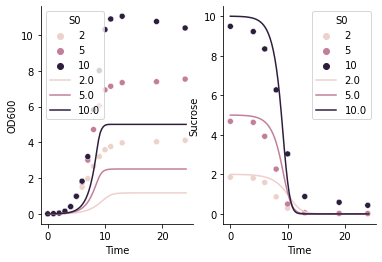

R2 = 0.237 (growth),-6.986 (sucrose)
Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 175.4391
Function value obtained: 22.8703
Current minimum: 22.4922
Iteration No: 110 started. Searching for the next optimal point.
mu: 3.150e-04,rho: 1.500e+02,ksuc: 1.202e+00, m 1.000e-09


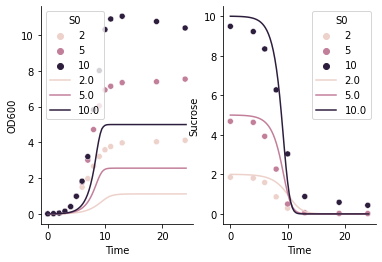

R2 = 0.227 (growth),-6.981 (sucrose)
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 168.0916
Function value obtained: 22.9516
Current minimum: 22.4922
Iteration No: 111 started. Searching for the next optimal point.
mu: 3.185e-04,rho: 1.500e+02,ksuc: 1.109e+00, m 1.000e-09


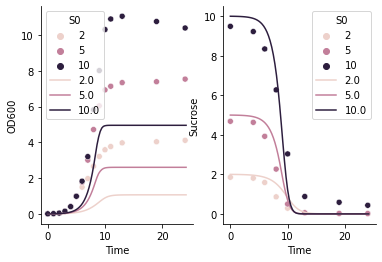

R2 = 0.234 (growth),-6.871 (sucrose)
Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 174.7421
Function value obtained: 22.9739
Current minimum: 22.4922
Iteration No: 112 started. Searching for the next optimal point.
mu: 3.156e-04,rho: 1.500e+02,ksuc: 1.287e+00, m 1.000e-09


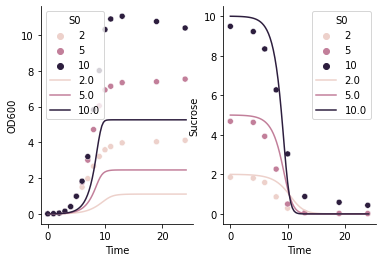

R2 = 0.243 (growth),-6.996 (sucrose)
Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 178.8992
Function value obtained: 22.7814
Current minimum: 22.4922
Iteration No: 113 started. Searching for the next optimal point.
mu: 3.188e-04,rho: 1.500e+02,ksuc: 1.187e+00, m 1.000e-09


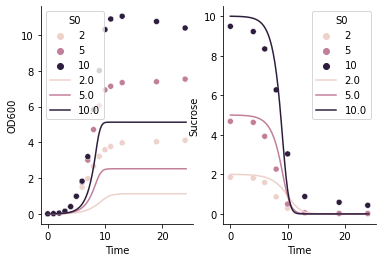

R2 = 0.254 (growth),-6.888 (sucrose)
Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 175.5633
Function value obtained: 22.7849
Current minimum: 22.4922
Iteration No: 114 started. Searching for the next optimal point.
mu: 3.148e-04,rho: 1.500e+02,ksuc: 1.300e+00, m 1.000e-09


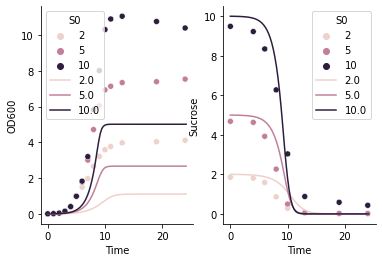

R2 = 0.219 (growth),-7.043 (sucrose)
Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 173.0923
Function value obtained: 22.9786
Current minimum: 22.4922
Iteration No: 115 started. Searching for the next optimal point.
mu: 3.204e-04,rho: 1.500e+02,ksuc: 1.116e+00, m 1.000e-09


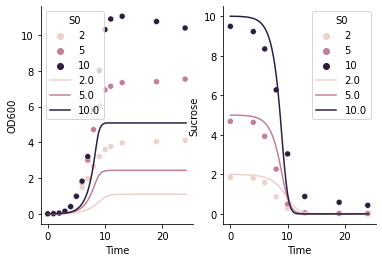

R2 = 0.258 (growth),-6.837 (sucrose)
Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 173.5898
Function value obtained: 22.8056
Current minimum: 22.4922
Iteration No: 116 started. Searching for the next optimal point.
mu: 3.202e-04,rho: 1.500e+02,ksuc: 1.115e+00, m 1.000e-09


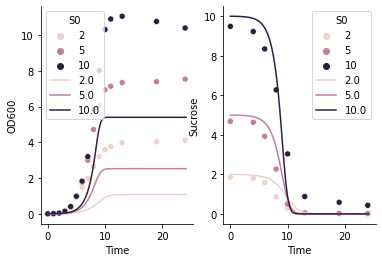

R2 = 0.280 (growth),-6.826 (sucrose)
Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 185.4206
Function value obtained: 22.5945
Current minimum: 22.4922
Iteration No: 117 started. Searching for the next optimal point.
mu: 3.204e-04,rho: 1.500e+02,ksuc: 1.063e+00, m 1.000e-09


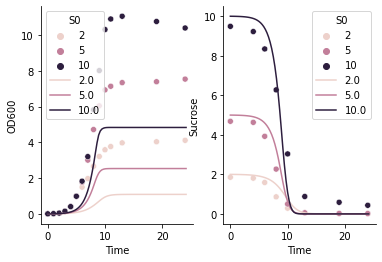

R2 = 0.234 (growth),-6.830 (sucrose)
Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 167.3959
Function value obtained: 23.0215
Current minimum: 22.4922
Iteration No: 118 started. Searching for the next optimal point.
mu: 3.204e-04,rho: 1.500e+02,ksuc: 1.124e+00, m 1.000e-09


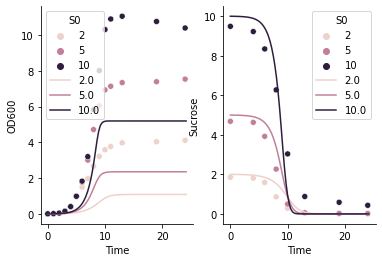

R2 = 0.264 (growth),-6.832 (sucrose)
Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 176.0191
Function value obtained: 22.7451
Current minimum: 22.4922
Iteration No: 119 started. Searching for the next optimal point.
mu: 3.204e-04,rho: 1.500e+02,ksuc: 1.107e+00, m 1.000e-09


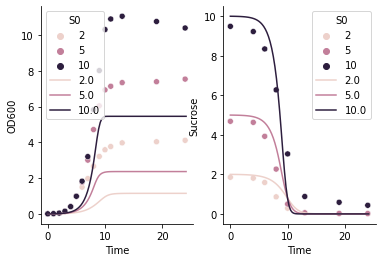

R2 = 0.296 (growth),-6.812 (sucrose)
Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 186.2766
Function value obtained: 22.4770
Current minimum: 22.4770
Iteration No: 120 started. Searching for the next optimal point.
mu: 3.208e-04,rho: 1.500e+02,ksuc: 1.033e+00, m 1.000e-09


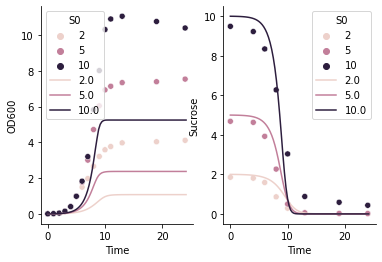

R2 = 0.278 (growth),-6.788 (sucrose)
Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 185.5982
Function value obtained: 22.6817
Current minimum: 22.4770
Iteration No: 121 started. Searching for the next optimal point.
mu: 3.207e-04,rho: 1.500e+02,ksuc: 1.004e+00, m 1.000e-09


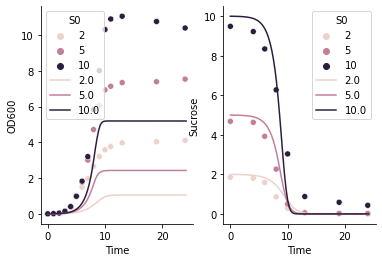

R2 = 0.273 (growth),-6.777 (sucrose)
Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 178.5266
Function value obtained: 22.7453
Current minimum: 22.4770
Iteration No: 122 started. Searching for the next optimal point.
mu: 3.205e-04,rho: 1.500e+02,ksuc: 9.884e-01, m 1.000e-09


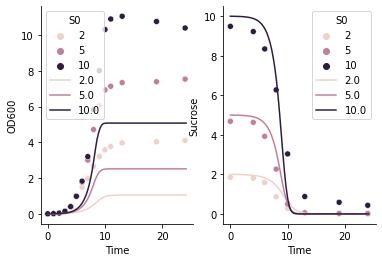

R2 = 0.260 (growth),-6.779 (sucrose)
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 171.4731
Function value obtained: 22.8456
Current minimum: 22.4770
Iteration No: 123 started. Searching for the next optimal point.
mu: 3.205e-04,rho: 1.500e+02,ksuc: 9.983e-01, m 1.000e-09


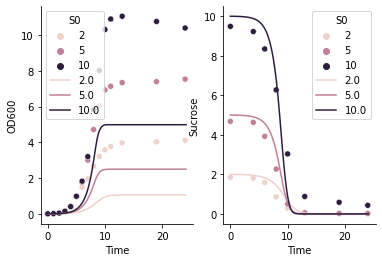

R2 = 0.253 (growth),-6.787 (sucrose)
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 172.0755
Function value obtained: 22.9065
Current minimum: 22.4770
Iteration No: 124 started. Searching for the next optimal point.
mu: 3.206e-04,rho: 1.500e+02,ksuc: 1.023e+00, m 1.000e-09


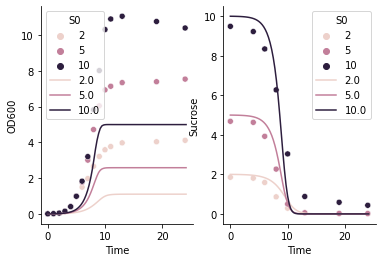

R2 = 0.258 (growth),-6.796 (sucrose)
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 173.6642
Function value obtained: 22.8603
Current minimum: 22.4770
Iteration No: 125 started. Searching for the next optimal point.
mu: 3.208e-04,rho: 1.500e+02,ksuc: 1.034e+00, m 1.000e-09


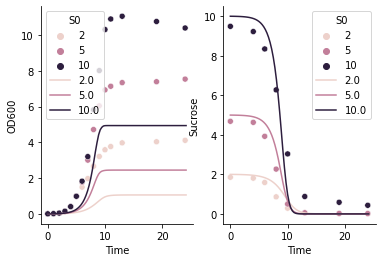

R2 = 0.243 (growth),-6.808 (sucrose)
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 169.5958
Function value obtained: 22.9614
Current minimum: 22.4770
Iteration No: 126 started. Searching for the next optimal point.
mu: 3.205e-04,rho: 1.500e+02,ksuc: 1.074e+00, m 1.000e-09


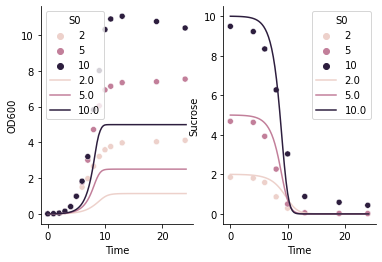

R2 = 0.255 (growth),-6.826 (sucrose)
Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 177.2269
Function value obtained: 22.8477
Current minimum: 22.4770
Iteration No: 127 started. Searching for the next optimal point.
mu: 3.203e-04,rho: 1.500e+02,ksuc: 1.084e+00, m 1.000e-09


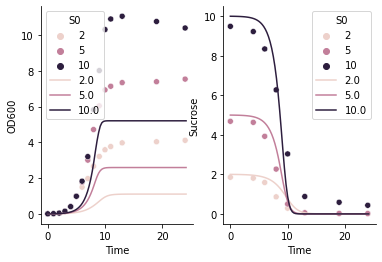

R2 = 0.271 (growth),-6.816 (sucrose)
Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 176.9369
Function value obtained: 22.7086
Current minimum: 22.4770
Iteration No: 128 started. Searching for the next optimal point.
mu: 3.203e-04,rho: 1.500e+02,ksuc: 1.063e+00, m 1.000e-09


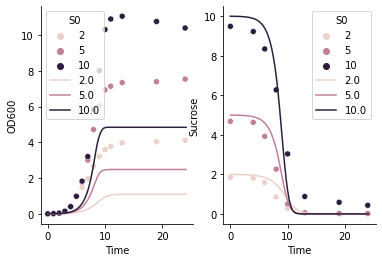

R2 = 0.233 (growth),-6.842 (sucrose)
Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 164.2139
Function value obtained: 23.0272
Current minimum: 22.4770
Iteration No: 129 started. Searching for the next optimal point.
mu: 3.147e-04,rho: 1.500e+02,ksuc: 1.258e+00, m 1.000e-09


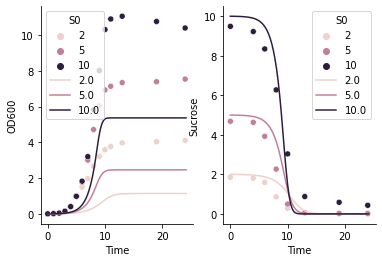

R2 = 0.259 (growth),-6.969 (sucrose)
Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 181.1071
Function value obtained: 22.6549
Current minimum: 22.4770
Iteration No: 130 started. Searching for the next optimal point.
mu: 3.144e-04,rho: 1.500e+02,ksuc: 1.284e+00, m 1.000e-09


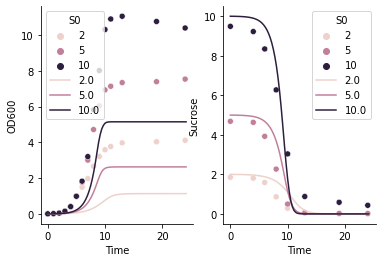

R2 = 0.232 (growth),-7.041 (sucrose)
Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 172.6553
Function value obtained: 22.8590
Current minimum: 22.4770
Iteration No: 131 started. Searching for the next optimal point.
mu: 3.147e-04,rho: 1.500e+02,ksuc: 1.279e+00, m 1.000e-09


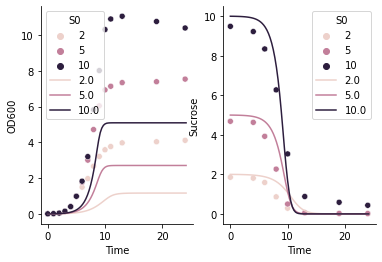

R2 = 0.236 (growth),-7.013 (sucrose)
Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 174.0627
Function value obtained: 22.8489
Current minimum: 22.4770
Iteration No: 132 started. Searching for the next optimal point.
mu: 3.149e-04,rho: 1.500e+02,ksuc: 1.276e+00, m 1.000e-09


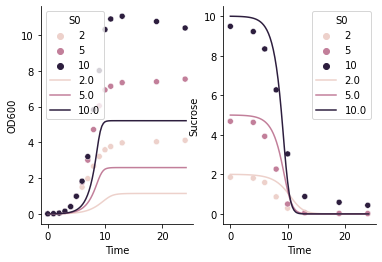

R2 = 0.244 (growth),-7.001 (sucrose)
Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 186.0183
Function value obtained: 22.7722
Current minimum: 22.4770
Iteration No: 133 started. Searching for the next optimal point.
mu: 3.112e-04,rho: 1.500e+02,ksuc: 1.461e+00, m 1.000e-09


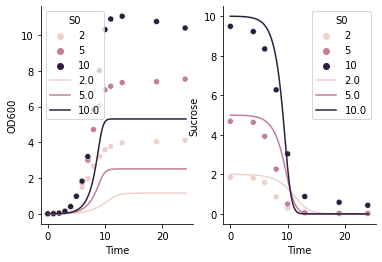

R2 = 0.221 (growth),-7.249 (sucrose)
Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 182.7135
Function value obtained: 22.8591
Current minimum: 22.4770
Iteration No: 134 started. Searching for the next optimal point.
mu: 3.148e-04,rho: 1.500e+02,ksuc: 1.264e+00, m 1.000e-09


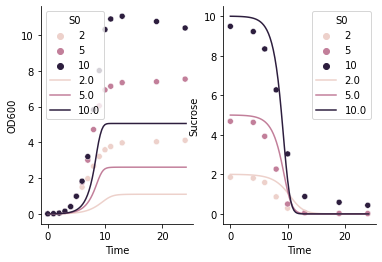

R2 = 0.224 (growth),-7.018 (sucrose)
Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 171.0621
Function value obtained: 22.9435
Current minimum: 22.4770
Iteration No: 135 started. Searching for the next optimal point.
mu: 3.198e-04,rho: 1.500e+02,ksuc: 1.125e+00, m 1.000e-09


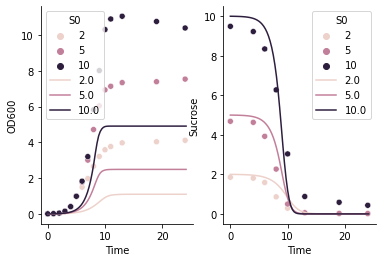

R2 = 0.237 (growth),-6.865 (sucrose)
Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 169.9719
Function value obtained: 22.9660
Current minimum: 22.4770
Iteration No: 136 started. Searching for the next optimal point.
mu: 3.168e-04,rho: 1.500e+02,ksuc: 1.274e+00, m 1.000e-09


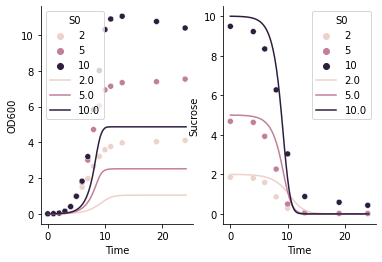

R2 = 0.200 (growth),-7.027 (sucrose)
Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 169.0147
Function value obtained: 23.1512
Current minimum: 22.4770
Iteration No: 137 started. Searching for the next optimal point.
mu: 3.231e-04,rho: 1.500e+02,ksuc: 1.119e+00, m 1.000e-09


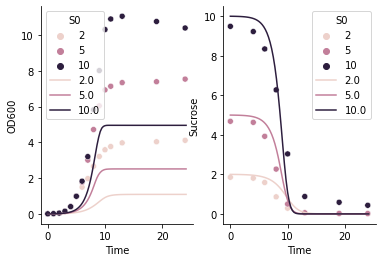

R2 = 0.241 (growth),-6.834 (sucrose)
Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 177.6349
Function value obtained: 22.9509
Current minimum: 22.4770
Iteration No: 138 started. Searching for the next optimal point.
mu: 3.228e-04,rho: 1.500e+02,ksuc: 1.143e+00, m 1.000e-09


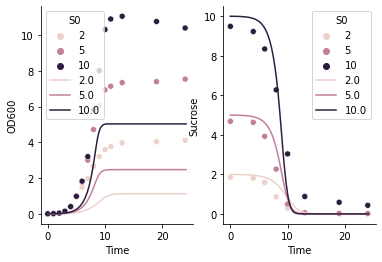

R2 = 0.257 (growth),-6.831 (sucrose)
Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 179.3490
Function value obtained: 22.8216
Current minimum: 22.4770
Iteration No: 139 started. Searching for the next optimal point.
mu: 3.226e-04,rho: 1.500e+02,ksuc: 1.143e+00, m 1.000e-09


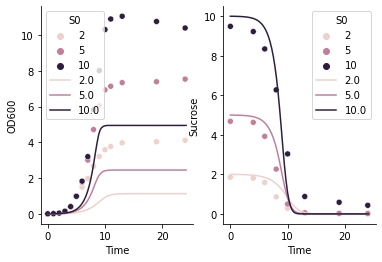

R2 = 0.247 (growth),-6.841 (sucrose)
Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 177.2018
Function value obtained: 22.8983
Current minimum: 22.4770
Iteration No: 140 started. Searching for the next optimal point.
mu: 3.170e-04,rho: 1.500e+02,ksuc: 1.275e+00, m 1.000e-09


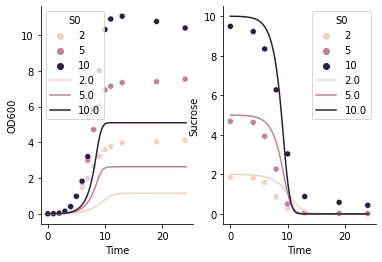

R2 = 0.237 (growth),-6.998 (sucrose)
Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 177.1090
Function value obtained: 22.8506
Current minimum: 22.4770
Iteration No: 141 started. Searching for the next optimal point.
mu: 3.149e-04,rho: 1.500e+02,ksuc: 1.271e+00, m 1.000e-09


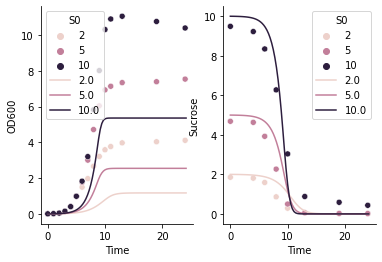

R2 = 0.260 (growth),-6.978 (sucrose)
Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 180.6417
Function value obtained: 22.6369
Current minimum: 22.4770
Iteration No: 142 started. Searching for the next optimal point.
mu: 3.147e-04,rho: 1.500e+02,ksuc: 1.287e+00, m 1.000e-09


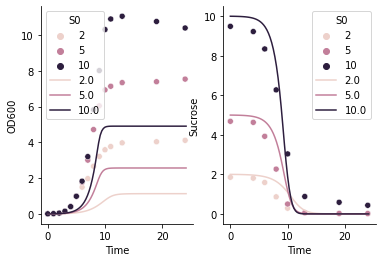

R2 = 0.210 (growth),-7.067 (sucrose)
Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 167.7517
Function value obtained: 23.0485
Current minimum: 22.4770
Iteration No: 143 started. Searching for the next optimal point.
mu: 3.229e-04,rho: 1.500e+02,ksuc: 1.142e+00, m 1.000e-09


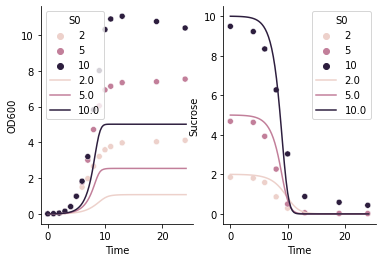

R2 = 0.245 (growth),-6.839 (sucrose)
Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 171.9573
Function value obtained: 22.9089
Current minimum: 22.4770
Iteration No: 144 started. Searching for the next optimal point.
mu: 3.224e-04,rho: 1.500e+02,ksuc: 1.154e+00, m 1.000e-09


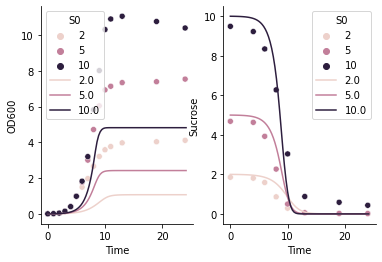

R2 = 0.227 (growth),-6.848 (sucrose)
Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 170.8001
Function value obtained: 23.0670
Current minimum: 22.4770
Iteration No: 145 started. Searching for the next optimal point.
mu: 3.155e-04,rho: 1.500e+02,ksuc: 1.303e+00, m 1.000e-09


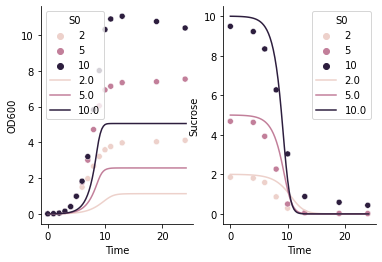

R2 = 0.227 (growth),-7.026 (sucrose)
Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 176.3769
Function value obtained: 22.9151
Current minimum: 22.4770
Iteration No: 146 started. Searching for the next optimal point.
mu: 3.165e-04,rho: 1.500e+02,ksuc: 1.295e+00, m 1.000e-09


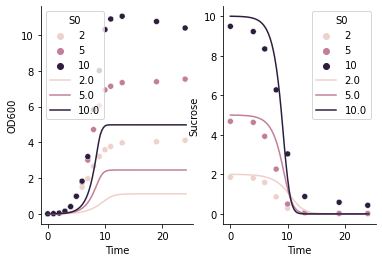

R2 = 0.218 (growth),-7.032 (sucrose)
Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 170.1518
Function value obtained: 22.9965
Current minimum: 22.4770
Iteration No: 147 started. Searching for the next optimal point.
mu: 3.234e-04,rho: 1.500e+02,ksuc: 1.148e+00, m 1.000e-09


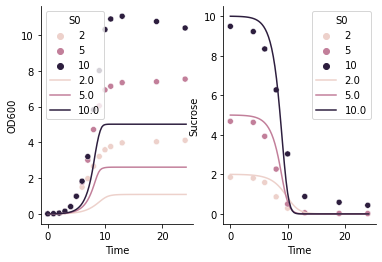

R2 = 0.246 (growth),-6.838 (sucrose)
Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 176.6280
Function value obtained: 22.8992
Current minimum: 22.4770
Iteration No: 148 started. Searching for the next optimal point.
mu: 3.230e-04,rho: 1.500e+02,ksuc: 1.159e+00, m 1.000e-09


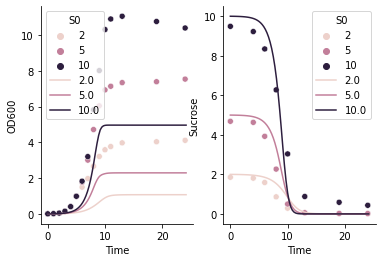

R2 = 0.241 (growth),-6.841 (sucrose)
Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 180.3375
Function value obtained: 22.9477
Current minimum: 22.4770
Iteration No: 149 started. Searching for the next optimal point.
mu: 3.119e-04,rho: 1.500e+02,ksuc: 1.410e+00, m 1.000e-09


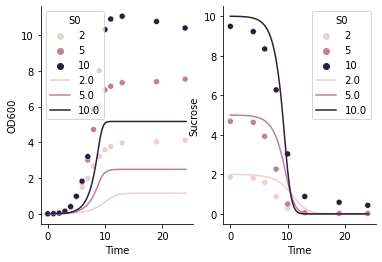

R2 = 0.218 (growth),-7.195 (sucrose)
Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 178.1857
Function value obtained: 22.9139
Current minimum: 22.4770
Iteration No: 150 started. Searching for the next optimal point.
mu: 3.220e-04,rho: 1.500e+02,ksuc: 1.124e+00, m 1.000e-09


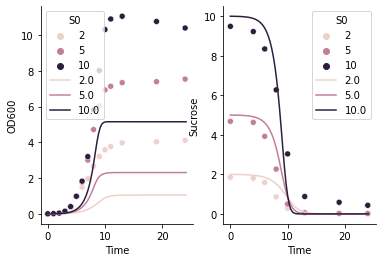

R2 = 0.256 (growth),-6.824 (sucrose)
Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 176.9266
Function value obtained: 22.8177
Current minimum: 22.4770
Iteration No: 151 started. Searching for the next optimal point.
mu: 3.211e-04,rho: 1.500e+02,ksuc: 1.103e+00, m 1.000e-09


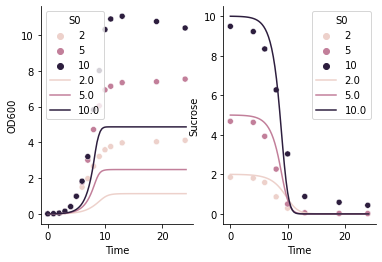

R2 = 0.242 (growth),-6.836 (sucrose)
Iteration No: 151 ended. Search finished for the next optimal point.
Time taken: 171.2190
Function value obtained: 22.9576
Current minimum: 22.4770
Iteration No: 152 started. Searching for the next optimal point.
mu: 3.234e-04,rho: 1.500e+02,ksuc: 1.271e+00, m 1.000e-09


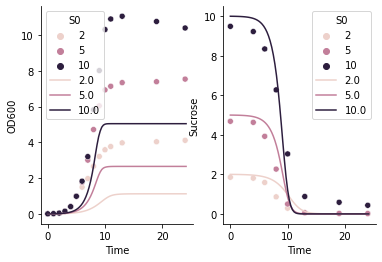

R2 = 0.244 (growth),-6.890 (sucrose)
Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 175.1464
Function value obtained: 22.8684
Current minimum: 22.4770
Iteration No: 153 started. Searching for the next optimal point.
mu: 3.166e-04,rho: 1.500e+02,ksuc: 1.098e+00, m 1.000e-09


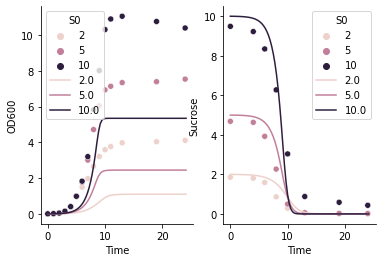

R2 = 0.275 (growth),-6.849 (sucrose)
Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 186.0153
Function value obtained: 22.6220
Current minimum: 22.4770
Iteration No: 154 started. Searching for the next optimal point.
mu: 3.161e-04,rho: 1.500e+02,ksuc: 1.044e+00, m 1.000e-09


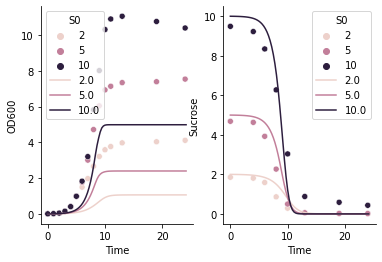

R2 = 0.237 (growth),-6.865 (sucrose)
Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 181.3374
Function value obtained: 22.9525
Current minimum: 22.4770
Iteration No: 155 started. Searching for the next optimal point.
mu: 3.154e-04,rho: 1.500e+02,ksuc: 1.261e+00, m 1.000e-09


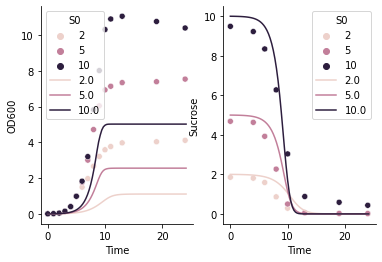

R2 = 0.223 (growth),-7.012 (sucrose)
Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 171.8618
Function value obtained: 22.9597
Current minimum: 22.4770
Iteration No: 156 started. Searching for the next optimal point.
mu: 3.233e-04,rho: 1.500e+02,ksuc: 1.168e+00, m 1.000e-09


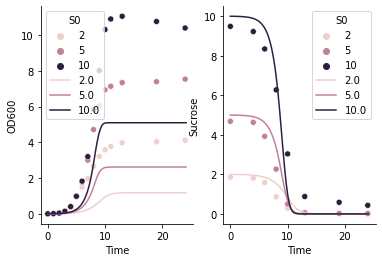

R2 = 0.267 (growth),-6.833 (sucrose)
Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 176.7090
Function value obtained: 22.7335
Current minimum: 22.4770
Iteration No: 157 started. Searching for the next optimal point.
mu: 3.237e-04,rho: 1.500e+02,ksuc: 1.161e+00, m 1.000e-09


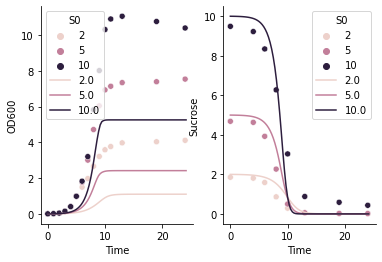

R2 = 0.274 (growth),-6.816 (sucrose)
Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 179.8250
Function value obtained: 22.6797
Current minimum: 22.4770
Iteration No: 158 started. Searching for the next optimal point.
mu: 3.251e-04,rho: 1.500e+02,ksuc: 1.206e+00, m 1.000e-09


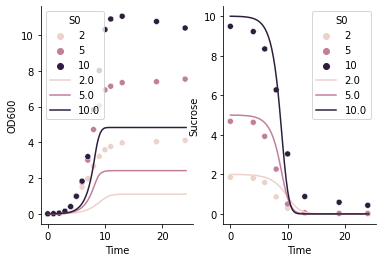

R2 = 0.228 (growth),-6.858 (sucrose)
Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 170.9413
Function value obtained: 23.0404
Current minimum: 22.4770
Iteration No: 159 started. Searching for the next optimal point.
mu: 3.185e-04,rho: 1.500e+02,ksuc: 1.043e+00, m 1.000e-09


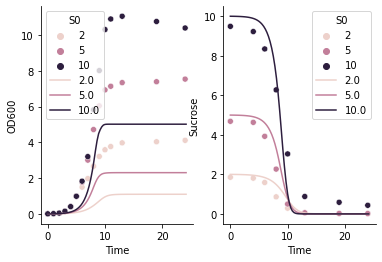

R2 = 0.254 (growth),-6.825 (sucrose)
Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 174.2862
Function value obtained: 22.8580
Current minimum: 22.4770
Iteration No: 160 started. Searching for the next optimal point.
mu: 3.193e-04,rho: 1.500e+02,ksuc: 1.064e+00, m 1.000e-09


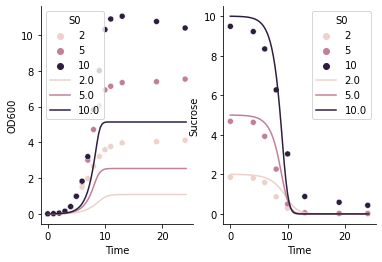

R2 = 0.261 (growth),-6.827 (sucrose)
Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 173.7200
Function value obtained: 22.7856
Current minimum: 22.4770
Iteration No: 161 started. Searching for the next optimal point.
mu: 3.181e-04,rho: 1.500e+02,ksuc: 1.040e+00, m 1.000e-09


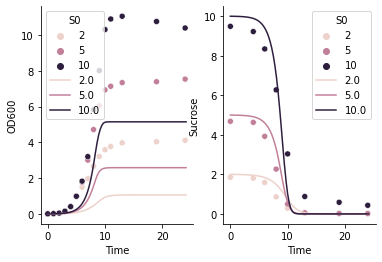

R2 = 0.257 (growth),-6.827 (sucrose)
Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 182.8255
Function value obtained: 22.8097
Current minimum: 22.4770
Iteration No: 162 started. Searching for the next optimal point.
mu: 3.178e-04,rho: 1.500e+02,ksuc: 1.034e+00, m 1.000e-09


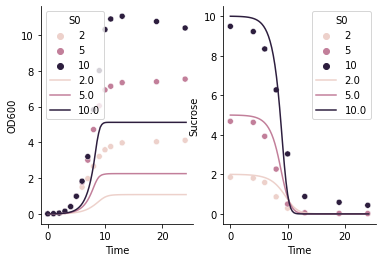

R2 = 0.259 (growth),-6.826 (sucrose)
Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 179.2430
Function value obtained: 22.8014
Current minimum: 22.4770
Iteration No: 163 started. Searching for the next optimal point.
mu: 3.173e-04,rho: 1.500e+02,ksuc: 1.025e+00, m 1.000e-09


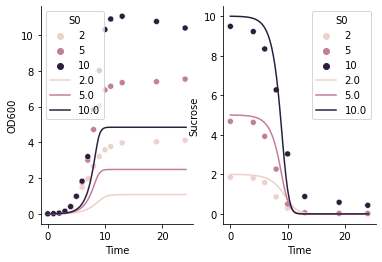

R2 = 0.231 (growth),-6.852 (sucrose)
Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 169.8695
Function value obtained: 23.0296
Current minimum: 22.4770
Iteration No: 164 started. Searching for the next optimal point.
mu: 3.240e-04,rho: 1.500e+02,ksuc: 1.273e+00, m 1.000e-09


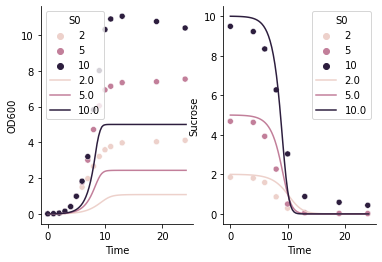

R2 = 0.234 (growth),-6.884 (sucrose)
Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 173.3829
Function value obtained: 22.9485
Current minimum: 22.4770
Iteration No: 165 started. Searching for the next optimal point.
mu: 3.231e-04,rho: 1.500e+02,ksuc: 1.148e+00, m 1.000e-09


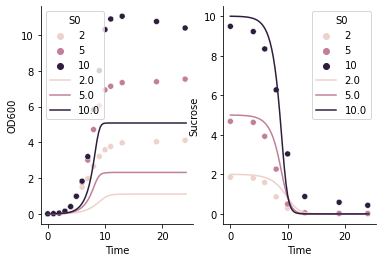

R2 = 0.260 (growth),-6.825 (sucrose)
Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 185.5464
Function value obtained: 22.7990
Current minimum: 22.4770
Iteration No: 166 started. Searching for the next optimal point.
mu: 3.233e-04,rho: 1.500e+02,ksuc: 1.242e+00, m 1.000e-09


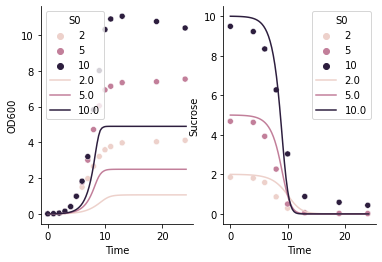

R2 = 0.226 (growth),-6.878 (sucrose)
Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 173.2515
Function value obtained: 23.0310
Current minimum: 22.4770
Iteration No: 167 started. Searching for the next optimal point.
mu: 3.141e-04,rho: 1.500e+02,ksuc: 1.220e+00, m 1.000e-09


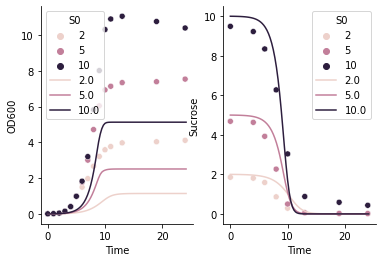

R2 = 0.237 (growth),-7.010 (sucrose)
Iteration No: 167 ended. Search finished for the next optimal point.
Time taken: 183.9119
Function value obtained: 22.8447
Current minimum: 22.4770
Iteration No: 168 started. Searching for the next optimal point.
mu: 3.141e-04,rho: 1.500e+02,ksuc: 1.219e+00, m 1.000e-09


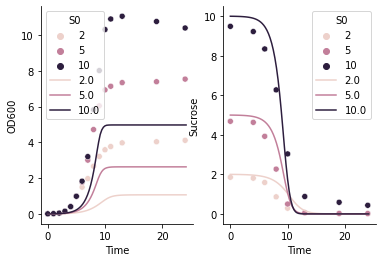

R2 = 0.214 (growth),-7.019 (sucrose)
Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 175.0164
Function value obtained: 23.0369
Current minimum: 22.4770
Iteration No: 169 started. Searching for the next optimal point.
mu: 3.241e-04,rho: 1.500e+02,ksuc: 1.175e+00, m 1.000e-09


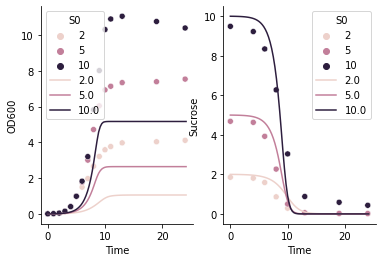

R2 = 0.259 (growth),-6.826 (sucrose)
Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 188.0311
Function value obtained: 22.7962
Current minimum: 22.4770
Iteration No: 170 started. Searching for the next optimal point.
mu: 3.243e-04,rho: 1.500e+02,ksuc: 1.173e+00, m 1.000e-09


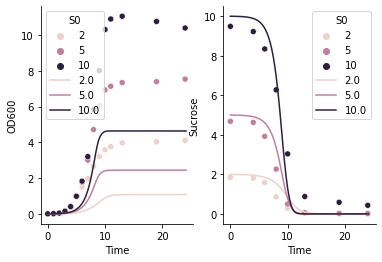

R2 = 0.204 (growth),-6.870 (sucrose)
Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 159.1395
Function value obtained: 23.2391
Current minimum: 22.4770
Iteration No: 171 started. Searching for the next optimal point.
mu: 3.173e-04,rho: 1.500e+02,ksuc: 1.131e+00, m 1.000e-07


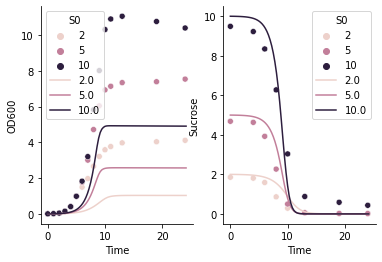

R2 = 0.220 (growth),-6.917 (sucrose)
Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 177.7355
Function value obtained: 23.0512
Current minimum: 22.4770
Iteration No: 172 started. Searching for the next optimal point.
mu: 3.190e-04,rho: 1.500e+02,ksuc: 1.356e+00, m 1.000e-09


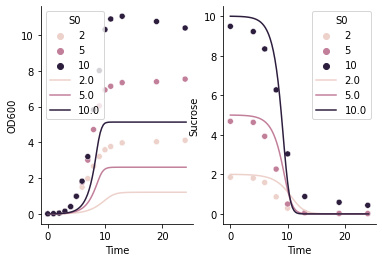

R2 = 0.245 (growth),-6.994 (sucrose)
Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 178.7096
Function value obtained: 22.7819
Current minimum: 22.4770
Iteration No: 173 started. Searching for the next optimal point.
mu: 3.180e-04,rho: 1.500e+02,ksuc: 1.357e+00, m 1.000e-09


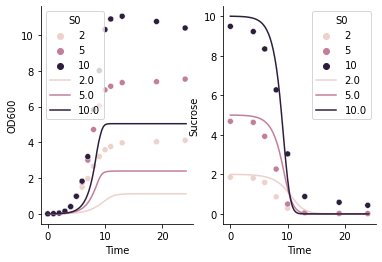

R2 = 0.223 (growth),-7.032 (sucrose)
Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 173.0085
Function value obtained: 22.9484
Current minimum: 22.4770
Iteration No: 174 started. Searching for the next optimal point.
mu: 3.227e-04,rho: 1.500e+02,ksuc: 1.342e+00, m 1.000e-09


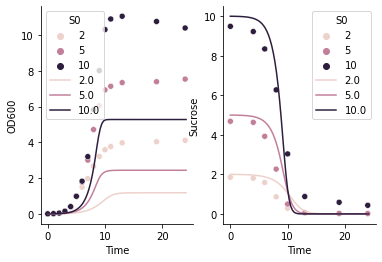

R2 = 0.263 (growth),-6.914 (sucrose)
Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 184.1757
Function value obtained: 22.6629
Current minimum: 22.4770
Iteration No: 175 started. Searching for the next optimal point.
mu: 3.235e-04,rho: 1.500e+02,ksuc: 1.363e+00, m 1.000e-09


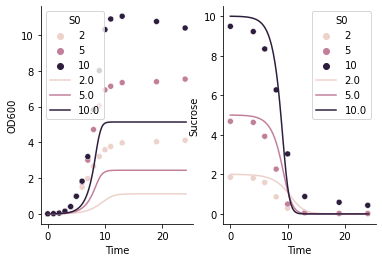

R2 = 0.242 (growth),-6.936 (sucrose)
Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 186.1180
Function value obtained: 22.8385
Current minimum: 22.4770
Iteration No: 176 started. Searching for the next optimal point.
mu: 3.233e-04,rho: 1.500e+02,ksuc: 1.365e+00, m 1.000e-09


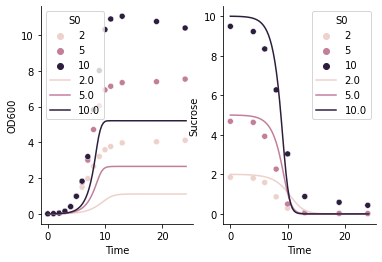

R2 = 0.248 (growth),-6.935 (sucrose)
Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 183.1382
Function value obtained: 22.7805
Current minimum: 22.4770
Iteration No: 177 started. Searching for the next optimal point.
mu: 3.233e-04,rho: 1.500e+02,ksuc: 1.373e+00, m 1.000e-09


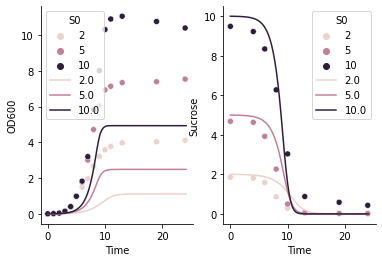

R2 = 0.220 (growth),-6.968 (sucrose)
Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 174.4428
Function value obtained: 23.0166
Current minimum: 22.4770
Iteration No: 178 started. Searching for the next optimal point.
mu: 3.225e-04,rho: 1.500e+02,ksuc: 1.348e+00, m 1.000e-09


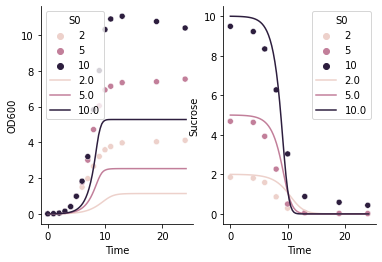

R2 = 0.259 (growth),-6.912 (sucrose)
Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 183.0910
Function value obtained: 22.7005
Current minimum: 22.4770
Iteration No: 179 started. Searching for the next optimal point.
mu: 3.230e-04,rho: 1.500e+02,ksuc: 1.366e+00, m 1.000e-09


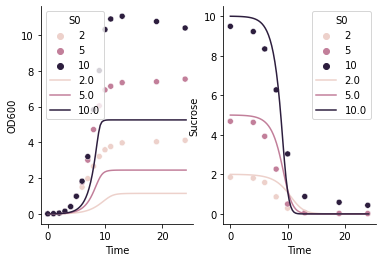

R2 = 0.261 (growth),-6.905 (sucrose)
Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 186.4732
Function value obtained: 22.6884
Current minimum: 22.4770
Iteration No: 180 started. Searching for the next optimal point.
mu: 3.235e-04,rho: 1.500e+02,ksuc: 1.384e+00, m 1.000e-09


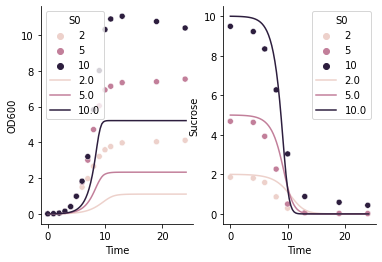

R2 = 0.247 (growth),-6.927 (sucrose)
Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 175.5841
Function value obtained: 22.7871
Current minimum: 22.4770
Iteration No: 181 started. Searching for the next optimal point.
mu: 3.235e-04,rho: 1.500e+02,ksuc: 1.391e+00, m 1.000e-09


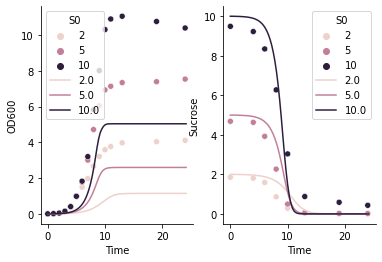

R2 = 0.234 (growth),-6.962 (sucrose)
Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 173.8412
Function value obtained: 22.8971
Current minimum: 22.4770
Iteration No: 182 started. Searching for the next optimal point.
mu: 3.233e-04,rho: 1.500e+02,ksuc: 1.383e+00, m 1.000e-09


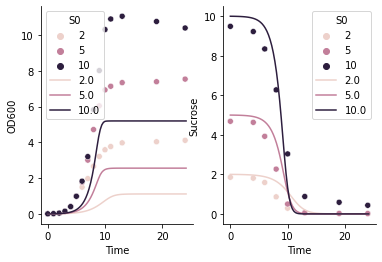

R2 = 0.245 (growth),-6.937 (sucrose)
Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 181.5483
Function value obtained: 22.7977
Current minimum: 22.4770
Iteration No: 183 started. Searching for the next optimal point.
mu: 3.228e-04,rho: 1.500e+02,ksuc: 1.390e+00, m 1.000e-09


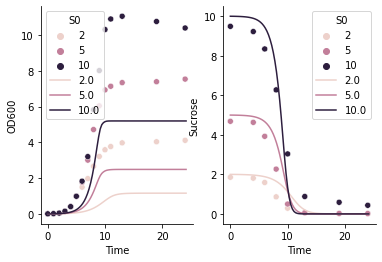

R2 = 0.249 (growth),-6.941 (sucrose)
Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 179.0527
Function value obtained: 22.7669
Current minimum: 22.4770
Iteration No: 184 started. Searching for the next optimal point.
mu: 3.228e-04,rho: 1.500e+02,ksuc: 1.400e+00, m 1.000e-09


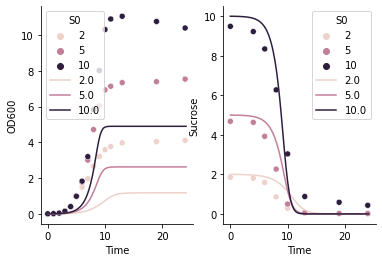

R2 = 0.218 (growth),-6.997 (sucrose)
Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 169.5297
Function value obtained: 23.0127
Current minimum: 22.4770
Iteration No: 185 started. Searching for the next optimal point.
mu: 3.219e-04,rho: 1.500e+02,ksuc: 1.380e+00, m 1.000e-09


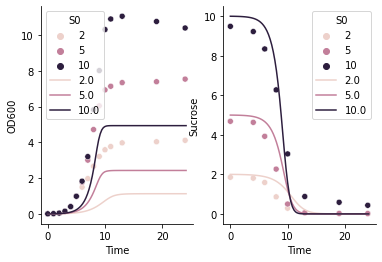

R2 = 0.219 (growth),-6.986 (sucrose)
Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 174.3204
Function value obtained: 23.0134
Current minimum: 22.4770
Iteration No: 186 started. Searching for the next optimal point.
mu: 3.252e-04,rho: 1.500e+02,ksuc: 1.281e+00, m 1.000e-09


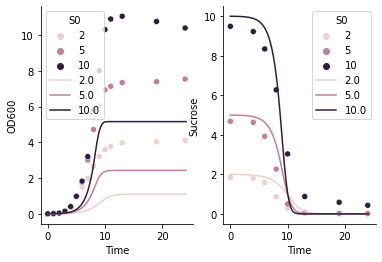

R2 = 0.256 (growth),-6.861 (sucrose)
Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 176.2715
Function value obtained: 22.7852
Current minimum: 22.4770
Iteration No: 187 started. Searching for the next optimal point.
mu: 3.254e-04,rho: 1.500e+02,ksuc: 1.284e+00, m 1.000e-09


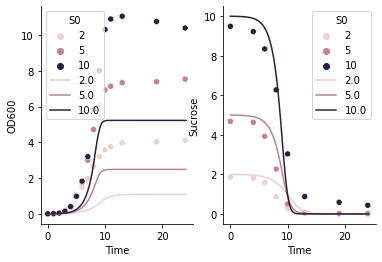

R2 = 0.261 (growth),-6.852 (sucrose)
Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 181.2139
Function value obtained: 22.7438
Current minimum: 22.4770
Iteration No: 188 started. Searching for the next optimal point.
mu: 3.259e-04,rho: 1.500e+02,ksuc: 1.287e+00, m 1.000e-09


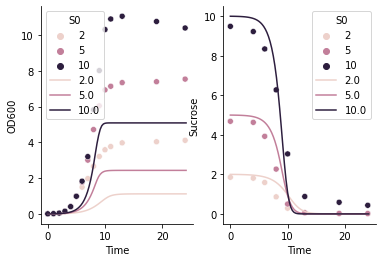

R2 = 0.251 (growth),-6.863 (sucrose)
Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 176.5617
Function value obtained: 22.8294
Current minimum: 22.4770
Iteration No: 189 started. Searching for the next optimal point.
mu: 3.198e-04,rho: 1.500e+02,ksuc: 1.372e+00, m 1.000e-09


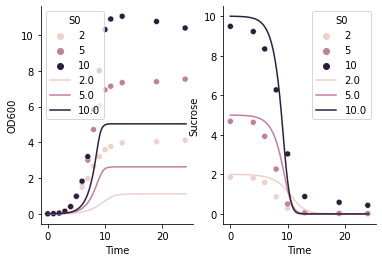

R2 = 0.223 (growth),-7.010 (sucrose)
Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 179.6034
Function value obtained: 22.9556
Current minimum: 22.4770
Iteration No: 190 started. Searching for the next optimal point.
mu: 3.260e-04,rho: 1.500e+02,ksuc: 1.239e+00, m 1.000e-09


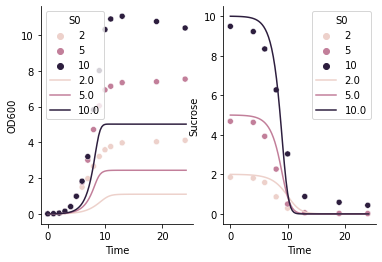

R2 = 0.246 (growth),-6.847 (sucrose)
Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 175.8259
Function value obtained: 22.8880
Current minimum: 22.4770
Iteration No: 191 started. Searching for the next optimal point.
mu: 3.257e-04,rho: 1.500e+02,ksuc: 1.238e+00, m 1.000e-09


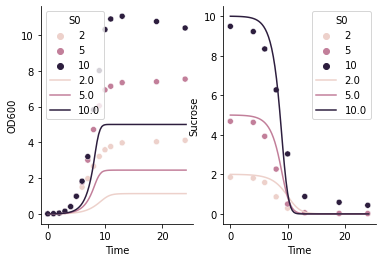

R2 = 0.251 (growth),-6.849 (sucrose)
Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 176.7333
Function value obtained: 22.8579
Current minimum: 22.4770
Iteration No: 192 started. Searching for the next optimal point.
mu: 3.255e-04,rho: 1.500e+02,ksuc: 1.239e+00, m 1.000e-09


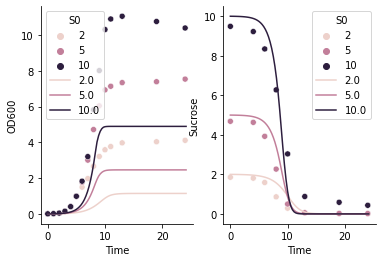

R2 = 0.239 (growth),-6.860 (sucrose)
Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 170.1279
Function value obtained: 22.9461
Current minimum: 22.4770
Iteration No: 193 started. Searching for the next optimal point.
mu: 3.158e-04,rho: 1.500e+02,ksuc: 1.299e+00, m 1.000e-09


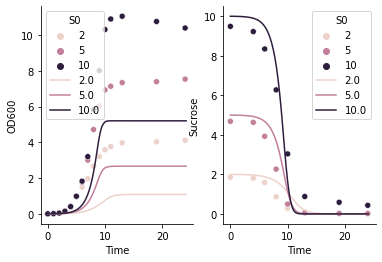

R2 = 0.236 (growth),-7.009 (sucrose)
Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 176.8046
Function value obtained: 22.8360
Current minimum: 22.4770
Iteration No: 194 started. Searching for the next optimal point.
mu: 3.157e-04,rho: 1.500e+02,ksuc: 1.298e+00, m 1.000e-09


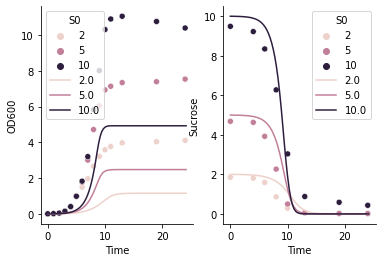

R2 = 0.215 (growth),-7.062 (sucrose)
Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 167.6962
Function value obtained: 23.0149
Current minimum: 22.4770
Iteration No: 195 started. Searching for the next optimal point.
mu: 3.253e-04,rho: 1.500e+02,ksuc: 1.197e+00, m 1.000e-09


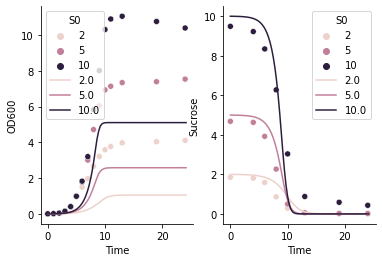

R2 = 0.255 (growth),-6.822 (sucrose)
Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 181.0553
Function value obtained: 22.8414
Current minimum: 22.4770
Iteration No: 196 started. Searching for the next optimal point.
mu: 3.252e-04,rho: 1.500e+02,ksuc: 1.196e+00, m 1.000e-09


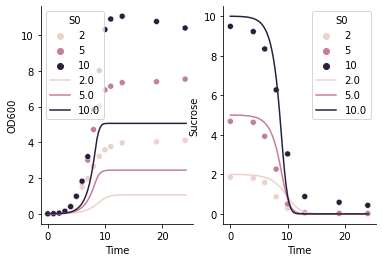

R2 = 0.253 (growth),-6.823 (sucrose)
Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 175.7780
Function value obtained: 22.8629
Current minimum: 22.4770
Iteration No: 197 started. Searching for the next optimal point.
mu: 3.303e-04,rho: 1.500e+02,ksuc: 1.059e+00, m 1.000e-09


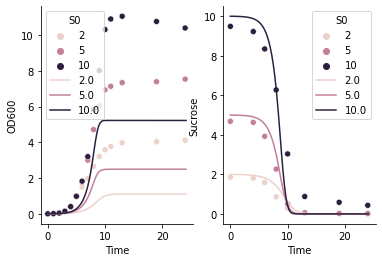

R2 = 0.295 (growth),-6.730 (sucrose)
Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 182.5062
Function value obtained: 22.6434
Current minimum: 22.4770
Iteration No: 198 started. Searching for the next optimal point.
mu: 3.265e-04,rho: 1.500e+02,ksuc: 1.157e+00, m 1.000e-09


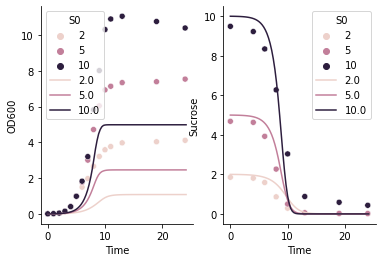

R2 = 0.249 (growth),-6.807 (sucrose)
Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 175.7121
Function value obtained: 22.9139
Current minimum: 22.4770
Iteration No: 199 started. Searching for the next optimal point.
mu: 3.261e-04,rho: 1.500e+02,ksuc: 1.158e+00, m 1.000e-09


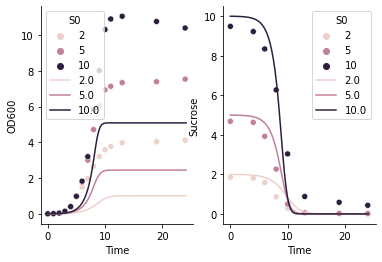

R2 = 0.252 (growth),-6.801 (sucrose)
Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 180.1674
Function value obtained: 22.8888
Current minimum: 22.4770
Iteration No: 200 started. Searching for the next optimal point.
mu: 3.258e-04,rho: 1.500e+02,ksuc: 1.158e+00, m 1.000e-09


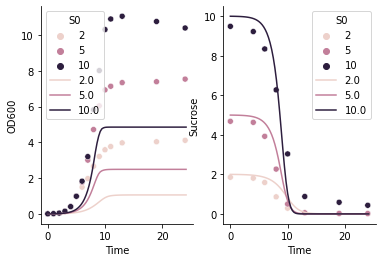

R2 = 0.230 (growth),-6.826 (sucrose)
Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 184.2577
Function value obtained: 23.0526
Current minimum: 22.4770


In [76]:
mu_min = float('5e-5')
mu_max = float('1e-3')
rho_min = 150
rho_max = 307
k_suc_min = float('1e-1')
k_suc_max = float('1.5e1')
m_min = float('1e-9')
m_max = float('1e-7')
checkpoint_saver = CheckpointSaver(r"/home/jsakkos/nufeb-cyano-e-coli/checkpoints/ecw.pkl", compress=9)
bounds = [(mu_min,mu_max),(rho_min,rho_max),(k_suc_min,k_suc_max),(m_min,m_max)]
n_calls = 200
gp_res = gp_minimize(func, bounds, n_calls=n_calls,n_initial_points=20,random_state=5348,verbose=True,callback=[tqdm_skopt(total=n_calls, desc="Gaussian Process"),checkpoint_saver])

In [ ]:
plot_convergence(gp_res,yscale='log')

In [ ]:
plot_objective(gp_res,dimensions=[r'$\mu$',r'$\rho$',r'$K_{sucrose}$','Maintenance'],cmap='inferno')

In [18]:
gp_res.x

[5.5e-05, 15.0, 6.047004917694896e-08]



Assigning ancestry:   0%|                                                                       | 0/173 [00:00<?, ?it/s]

Assigning ancestry:   4%|██▌                                                            | 7/173 [00:00<00:02, 63.10it/s]

Assigning ancestry:   8%|█████                                                         | 14/173 [00:00<00:02, 63.04it/s]

Assigning ancestry:  12%|███████▌                                                      | 21/173 [00:00<00:02, 63.57it/s]

Assigning ancestry:  16%|██████████                                                    | 28/173 [00:00<00:02, 63.60it/s]

Assigning ancestry:  20%|████████████▌                                                 | 35/173 [00:00<00:02, 63.38it/s]

Assigning ancestry:  24%|███████████████                                               | 42/173 [00:00<00:02, 63.86it/s]

Assigning ancestry:  28%|█████████████████▌                                            | 49/173 [00:00<00:01, 63.27it/s]

Assigning ancestry:  3

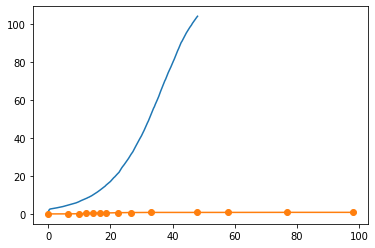

In [20]:
exp_x = np.array([ 0. ,  6.5, 10. , 12. , 14.5, 16.5, 18.5, 22.5, 26.5, 33. , 48. ,58. , 77. , 98. ])
exp_y = np.array([0.003, 0.025, 0.11 , 0.245, 0.388, 0.44 , 0.504, 0.64 , 0.725, 0.788, 0.79 , 0.8  , 0.825, 0.83 ])


os.chdir('/home/jonathan')
os.system('nufeb-clean')

    #Run simulation

text = f'nufeb-seed --cells 0,100 --grid 10 --t 17300 --suc 58.4 --muecw {gp_res.x[0]}  --rhoecw 250 --ksuc {gp_res.x[1]} --maintecw {gp_res.x[2]}'
os.system(text)
run_nufeb = subprocess.run('/home/jonathan/NUFEB/quickrun.sh', stdout=subprocess.DEVNULL)
os.chdir('/home/jonathan')
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
data = [utils.get_data(directory=str(x)) for x in folders]
Volume = 1e-4*1e-4*1e-5 #m^3
mlm3 = 1e6 #mL/m^3
cellsperOD=8e8 #cells/mL @OD 1
CellNum2OD = Volume*cellsperOD*mlm3

df = pd.concat([data[0].ntypes.ecw/CellNum2OD,data[0].ntypes.step/60/60*data[0].timestep],axis=1)
df.columns=['OD600','Hours']
f, ax = plt.subplots()
ax.plot(df.Hours,df.OD600,label='NUFEB')
ax.plot(exp_x,exp_y,marker='o',label='Experimental')
plt.show()